# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:12<00:00, 4.81KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

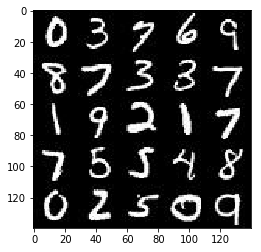

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

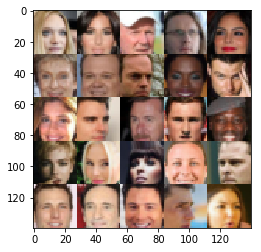

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_tensor = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs')
    z_tensor = tf.placeholder(tf.float32, [None, z_dim], name='z')
    learning_rate = tf.placeholder(tf.float32, name='lr')
    
    return real_input_tensor, z_tensor, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', use_bias=False)
        lrelu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same', use_bias=False)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding='same', use_bias=False)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x256

        x2 = tf.layers.conv2d_transpose(lrelu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128

        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3

        out = 0.5 * tf.tanh(logits)
        # Make output in [-0.5, 0.5]
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [30]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [31]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if 'discriminator' in var.name]
    g_vars = [var for var in t_vars if 'generator' in var.name]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [33]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, input_lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.2936... Generator Loss: 0.0601
Epoch 1/2... Discriminator Loss: 2.2065... Generator Loss: 0.2846
Epoch 1/2... Discriminator Loss: 6.7329... Generator Loss: 0.1205
Epoch 1/2... Discriminator Loss: 2.1713... Generator Loss: 0.2756
Epoch 1/2... Discriminator Loss: 1.2292... Generator Loss: 0.6680
Epoch 1/2... Discriminator Loss: 1.0301... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 0.5729... Generator Loss: 2.1426
Epoch 1/2... Discriminator Loss: 1.5228... Generator Loss: 0.3789
Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 1.5395
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.7639


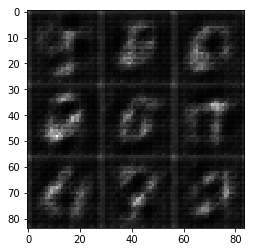

Epoch 1/2... Discriminator Loss: 0.9984... Generator Loss: 0.6421
Epoch 1/2... Discriminator Loss: 1.0307... Generator Loss: 1.0048
Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 1.6114
Epoch 1/2... Discriminator Loss: 1.1053... Generator Loss: 1.8022
Epoch 1/2... Discriminator Loss: 1.0409... Generator Loss: 0.6959
Epoch 1/2... Discriminator Loss: 1.4574... Generator Loss: 2.2252
Epoch 1/2... Discriminator Loss: 0.8455... Generator Loss: 1.5849
Epoch 1/2... Discriminator Loss: 1.5942... Generator Loss: 0.2732
Epoch 1/2... Discriminator Loss: 1.0947... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 0.8517... Generator Loss: 1.3128


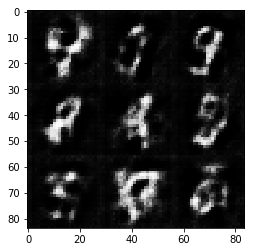

Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 1.6933
Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 0.4175
Epoch 1/2... Discriminator Loss: 0.8543... Generator Loss: 1.2130
Epoch 1/2... Discriminator Loss: 0.9265... Generator Loss: 0.7395
Epoch 1/2... Discriminator Loss: 0.7652... Generator Loss: 1.2162
Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 0.5577
Epoch 1/2... Discriminator Loss: 0.7606... Generator Loss: 1.6016
Epoch 1/2... Discriminator Loss: 0.6399... Generator Loss: 0.9946
Epoch 1/2... Discriminator Loss: 0.5987... Generator Loss: 1.2241
Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 1.4670


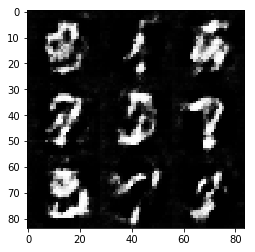

Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 0.6059
Epoch 1/2... Discriminator Loss: 0.8855... Generator Loss: 1.1021
Epoch 1/2... Discriminator Loss: 0.7003... Generator Loss: 1.1306
Epoch 1/2... Discriminator Loss: 0.8249... Generator Loss: 0.8455
Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 0.9876
Epoch 1/2... Discriminator Loss: 0.6955... Generator Loss: 1.0144
Epoch 1/2... Discriminator Loss: 1.4694... Generator Loss: 0.3668
Epoch 1/2... Discriminator Loss: 0.7640... Generator Loss: 1.5510
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 0.7127
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 2.4033


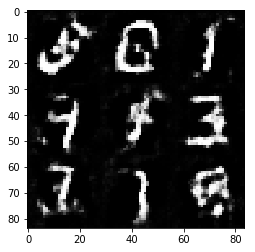

Epoch 1/2... Discriminator Loss: 0.6627... Generator Loss: 1.5975
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 0.5314
Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 0.5690
Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 0.4001
Epoch 1/2... Discriminator Loss: 0.8870... Generator Loss: 1.5840
Epoch 1/2... Discriminator Loss: 0.8109... Generator Loss: 2.0211
Epoch 1/2... Discriminator Loss: 1.1300... Generator Loss: 0.4861
Epoch 1/2... Discriminator Loss: 0.9683... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.4908
Epoch 1/2... Discriminator Loss: 0.7323... Generator Loss: 1.1843


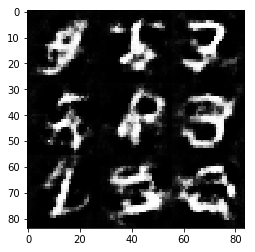

Epoch 1/2... Discriminator Loss: 0.8547... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 0.4960
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 1.4577
Epoch 1/2... Discriminator Loss: 1.4548... Generator Loss: 0.3590
Epoch 1/2... Discriminator Loss: 0.7783... Generator Loss: 0.9278
Epoch 1/2... Discriminator Loss: 0.9869... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 0.7177... Generator Loss: 1.2304
Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 0.9370
Epoch 1/2... Discriminator Loss: 0.8445... Generator Loss: 0.9234
Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 0.4080


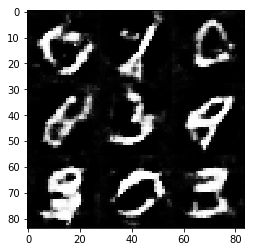

Epoch 1/2... Discriminator Loss: 1.4959... Generator Loss: 0.3760
Epoch 1/2... Discriminator Loss: 0.8366... Generator Loss: 1.7834
Epoch 1/2... Discriminator Loss: 0.5474... Generator Loss: 1.5469
Epoch 1/2... Discriminator Loss: 1.1624... Generator Loss: 0.5012
Epoch 1/2... Discriminator Loss: 0.7419... Generator Loss: 0.9190
Epoch 1/2... Discriminator Loss: 1.2470... Generator Loss: 0.5068
Epoch 1/2... Discriminator Loss: 0.6018... Generator Loss: 1.5230
Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 0.7440
Epoch 1/2... Discriminator Loss: 0.8939... Generator Loss: 1.1663
Epoch 1/2... Discriminator Loss: 0.9060... Generator Loss: 0.9015


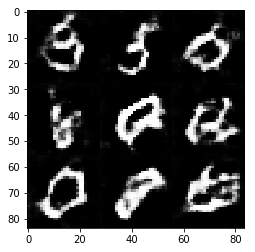

Epoch 1/2... Discriminator Loss: 0.8719... Generator Loss: 1.9639
Epoch 1/2... Discriminator Loss: 1.1903... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 1.5024... Generator Loss: 0.3468
Epoch 1/2... Discriminator Loss: 0.9438... Generator Loss: 1.9859
Epoch 1/2... Discriminator Loss: 0.7390... Generator Loss: 1.1081
Epoch 1/2... Discriminator Loss: 0.6364... Generator Loss: 1.2834
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 0.8230
Epoch 1/2... Discriminator Loss: 0.7907... Generator Loss: 1.2444
Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 0.6849
Epoch 1/2... Discriminator Loss: 0.9075... Generator Loss: 0.7560


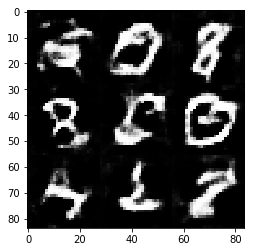

Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 0.3981
Epoch 1/2... Discriminator Loss: 1.5531... Generator Loss: 0.2930
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 0.4539
Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 0.6615
Epoch 1/2... Discriminator Loss: 0.7915... Generator Loss: 1.1222
Epoch 1/2... Discriminator Loss: 1.0855... Generator Loss: 0.6713
Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 0.6854
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 1.7261
Epoch 1/2... Discriminator Loss: 0.7280... Generator Loss: 1.2548
Epoch 1/2... Discriminator Loss: 0.8068... Generator Loss: 0.8545


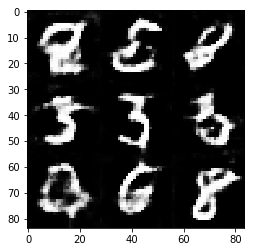

Epoch 1/2... Discriminator Loss: 0.9438... Generator Loss: 2.1273
Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 1.4167
Epoch 1/2... Discriminator Loss: 0.7239... Generator Loss: 1.3574
Epoch 1/2... Discriminator Loss: 0.9323... Generator Loss: 0.7542
Epoch 1/2... Discriminator Loss: 0.6226... Generator Loss: 1.1600
Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 2.2683
Epoch 1/2... Discriminator Loss: 1.0088... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 1.9459... Generator Loss: 0.2616
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 0.5961
Epoch 1/2... Discriminator Loss: 0.6339... Generator Loss: 1.2484


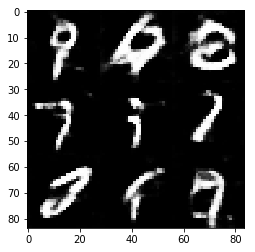

Epoch 1/2... Discriminator Loss: 1.4572... Generator Loss: 0.3664
Epoch 1/2... Discriminator Loss: 0.5467... Generator Loss: 1.5761
Epoch 1/2... Discriminator Loss: 3.0714... Generator Loss: 0.1181
Epoch 1/2... Discriminator Loss: 0.7379... Generator Loss: 0.8952
Epoch 1/2... Discriminator Loss: 0.7871... Generator Loss: 1.1227
Epoch 1/2... Discriminator Loss: 0.9902... Generator Loss: 0.6353
Epoch 1/2... Discriminator Loss: 1.0635... Generator Loss: 0.6417
Epoch 1/2... Discriminator Loss: 0.6050... Generator Loss: 1.3022
Epoch 1/2... Discriminator Loss: 2.6061... Generator Loss: 0.1261
Epoch 1/2... Discriminator Loss: 0.3780... Generator Loss: 1.7024


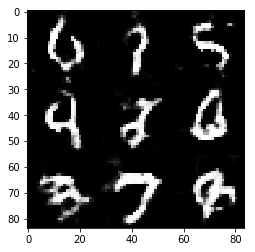

Epoch 1/2... Discriminator Loss: 0.7087... Generator Loss: 0.9355
Epoch 1/2... Discriminator Loss: 0.6976... Generator Loss: 3.2921
Epoch 1/2... Discriminator Loss: 0.9316... Generator Loss: 0.7324
Epoch 1/2... Discriminator Loss: 0.9781... Generator Loss: 0.6174
Epoch 1/2... Discriminator Loss: 0.9287... Generator Loss: 0.6181
Epoch 1/2... Discriminator Loss: 0.4427... Generator Loss: 1.3555
Epoch 1/2... Discriminator Loss: 2.7454... Generator Loss: 0.1419
Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 0.7582... Generator Loss: 1.1951
Epoch 1/2... Discriminator Loss: 0.6138... Generator Loss: 1.3583


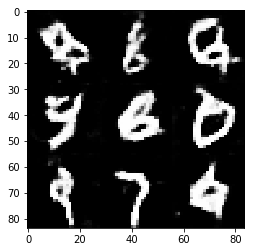

Epoch 1/2... Discriminator Loss: 0.7475... Generator Loss: 0.8934
Epoch 1/2... Discriminator Loss: 0.6810... Generator Loss: 1.1184
Epoch 1/2... Discriminator Loss: 0.6142... Generator Loss: 1.0621
Epoch 1/2... Discriminator Loss: 0.8930... Generator Loss: 1.6176
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 0.7170
Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 2.2573
Epoch 1/2... Discriminator Loss: 1.2867... Generator Loss: 1.8478
Epoch 1/2... Discriminator Loss: 0.9817... Generator Loss: 0.7748
Epoch 1/2... Discriminator Loss: 1.1218... Generator Loss: 0.5638
Epoch 1/2... Discriminator Loss: 0.7689... Generator Loss: 0.9556


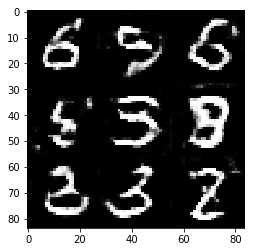

Epoch 1/2... Discriminator Loss: 1.0228... Generator Loss: 0.6437
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 0.4951
Epoch 1/2... Discriminator Loss: 0.9349... Generator Loss: 0.7501
Epoch 1/2... Discriminator Loss: 0.4448... Generator Loss: 1.7525
Epoch 1/2... Discriminator Loss: 1.7355... Generator Loss: 0.3199
Epoch 1/2... Discriminator Loss: 0.8702... Generator Loss: 0.8059
Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 0.5036
Epoch 1/2... Discriminator Loss: 1.9313... Generator Loss: 0.2391
Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 0.6508... Generator Loss: 2.0494


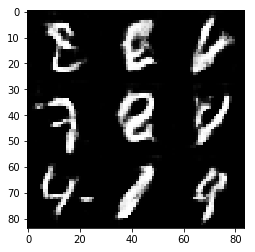

Epoch 1/2... Discriminator Loss: 0.5048... Generator Loss: 1.3221
Epoch 1/2... Discriminator Loss: 0.7613... Generator Loss: 0.9852
Epoch 1/2... Discriminator Loss: 0.5387... Generator Loss: 1.7131
Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 0.4416
Epoch 1/2... Discriminator Loss: 1.8384... Generator Loss: 4.0311
Epoch 1/2... Discriminator Loss: 0.6870... Generator Loss: 1.0635
Epoch 1/2... Discriminator Loss: 0.7260... Generator Loss: 1.1593
Epoch 1/2... Discriminator Loss: 1.0390... Generator Loss: 0.5810
Epoch 1/2... Discriminator Loss: 0.8367... Generator Loss: 1.5341
Epoch 1/2... Discriminator Loss: 1.2638... Generator Loss: 2.7319


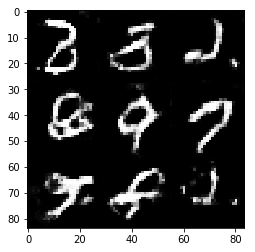

Epoch 1/2... Discriminator Loss: 0.4791... Generator Loss: 1.6580
Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 0.8083
Epoch 1/2... Discriminator Loss: 0.5757... Generator Loss: 1.3692
Epoch 1/2... Discriminator Loss: 0.4376... Generator Loss: 1.4260
Epoch 1/2... Discriminator Loss: 0.4503... Generator Loss: 1.4624
Epoch 1/2... Discriminator Loss: 1.0962... Generator Loss: 0.5702
Epoch 1/2... Discriminator Loss: 0.7864... Generator Loss: 0.8507
Epoch 1/2... Discriminator Loss: 0.7601... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 0.4517
Epoch 1/2... Discriminator Loss: 0.9959... Generator Loss: 0.7059


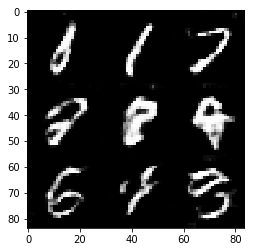

Epoch 1/2... Discriminator Loss: 1.0742... Generator Loss: 0.6694
Epoch 1/2... Discriminator Loss: 0.9120... Generator Loss: 0.7415
Epoch 1/2... Discriminator Loss: 0.3984... Generator Loss: 1.6337
Epoch 1/2... Discriminator Loss: 0.7054... Generator Loss: 0.8788
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 0.6494
Epoch 1/2... Discriminator Loss: 0.9288... Generator Loss: 0.6969
Epoch 1/2... Discriminator Loss: 0.7624... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 0.7611... Generator Loss: 0.8803
Epoch 1/2... Discriminator Loss: 0.9603... Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 0.9457... Generator Loss: 2.2124


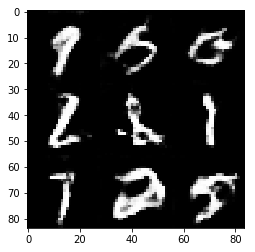

Epoch 1/2... Discriminator Loss: 0.7791... Generator Loss: 0.9453
Epoch 1/2... Discriminator Loss: 0.8530... Generator Loss: 1.7718
Epoch 1/2... Discriminator Loss: 0.8845... Generator Loss: 3.1434
Epoch 1/2... Discriminator Loss: 0.6623... Generator Loss: 1.1635
Epoch 1/2... Discriminator Loss: 0.4810... Generator Loss: 1.5403
Epoch 1/2... Discriminator Loss: 0.4979... Generator Loss: 2.0539
Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 0.5897
Epoch 1/2... Discriminator Loss: 0.7085... Generator Loss: 0.8790
Epoch 1/2... Discriminator Loss: 0.3192... Generator Loss: 1.8348
Epoch 1/2... Discriminator Loss: 0.6064... Generator Loss: 1.2291


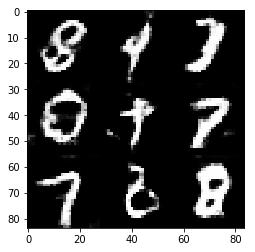

Epoch 1/2... Discriminator Loss: 0.8259... Generator Loss: 0.7780
Epoch 1/2... Discriminator Loss: 0.7058... Generator Loss: 0.9666
Epoch 1/2... Discriminator Loss: 0.4416... Generator Loss: 1.4520
Epoch 1/2... Discriminator Loss: 0.2915... Generator Loss: 1.6598
Epoch 1/2... Discriminator Loss: 0.7450... Generator Loss: 1.5409
Epoch 1/2... Discriminator Loss: 0.5181... Generator Loss: 2.4212
Epoch 1/2... Discriminator Loss: 0.6455... Generator Loss: 1.2679
Epoch 2/2... Discriminator Loss: 0.7753... Generator Loss: 0.9395
Epoch 2/2... Discriminator Loss: 0.7126... Generator Loss: 0.9716
Epoch 2/2... Discriminator Loss: 1.0912... Generator Loss: 0.6085


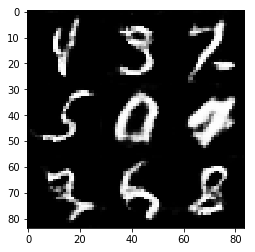

Epoch 2/2... Discriminator Loss: 0.5300... Generator Loss: 1.4090
Epoch 2/2... Discriminator Loss: 0.7895... Generator Loss: 0.9765
Epoch 2/2... Discriminator Loss: 1.4619... Generator Loss: 0.4786
Epoch 2/2... Discriminator Loss: 0.6390... Generator Loss: 1.0894
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 0.5747
Epoch 2/2... Discriminator Loss: 0.8418... Generator Loss: 0.8385
Epoch 2/2... Discriminator Loss: 0.6016... Generator Loss: 1.3553
Epoch 2/2... Discriminator Loss: 0.8200... Generator Loss: 0.8555
Epoch 2/2... Discriminator Loss: 0.8831... Generator Loss: 0.7051
Epoch 2/2... Discriminator Loss: 2.1283... Generator Loss: 0.1967


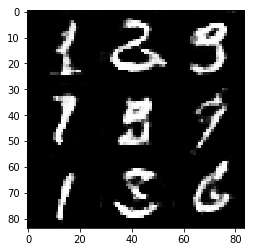

Epoch 2/2... Discriminator Loss: 1.1117... Generator Loss: 0.5861
Epoch 2/2... Discriminator Loss: 0.6527... Generator Loss: 1.4579
Epoch 2/2... Discriminator Loss: 1.0303... Generator Loss: 0.7856
Epoch 2/2... Discriminator Loss: 0.7714... Generator Loss: 0.8648
Epoch 2/2... Discriminator Loss: 0.4991... Generator Loss: 1.2608
Epoch 2/2... Discriminator Loss: 0.6565... Generator Loss: 0.9939
Epoch 2/2... Discriminator Loss: 0.9372... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 0.7137
Epoch 2/2... Discriminator Loss: 0.5415... Generator Loss: 1.6113
Epoch 2/2... Discriminator Loss: 1.9876... Generator Loss: 0.2607


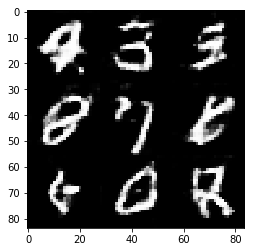

Epoch 2/2... Discriminator Loss: 0.5794... Generator Loss: 1.0627
Epoch 2/2... Discriminator Loss: 0.5436... Generator Loss: 1.1026
Epoch 2/2... Discriminator Loss: 0.4591... Generator Loss: 1.6056
Epoch 2/2... Discriminator Loss: 0.7773... Generator Loss: 0.8483
Epoch 2/2... Discriminator Loss: 0.4460... Generator Loss: 1.7888
Epoch 2/2... Discriminator Loss: 2.2467... Generator Loss: 0.2379
Epoch 2/2... Discriminator Loss: 1.1810... Generator Loss: 0.6549
Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 0.8720
Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 0.4683... Generator Loss: 1.9456


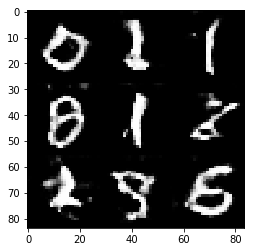

Epoch 2/2... Discriminator Loss: 0.8874... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 0.5268... Generator Loss: 1.1889
Epoch 2/2... Discriminator Loss: 0.8408... Generator Loss: 0.9065
Epoch 2/2... Discriminator Loss: 0.5388... Generator Loss: 1.1410
Epoch 2/2... Discriminator Loss: 0.4996... Generator Loss: 1.4261
Epoch 2/2... Discriminator Loss: 0.9897... Generator Loss: 0.7300
Epoch 2/2... Discriminator Loss: 0.7530... Generator Loss: 0.8532
Epoch 2/2... Discriminator Loss: 0.6622... Generator Loss: 1.0664
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 0.8656
Epoch 2/2... Discriminator Loss: 0.5636... Generator Loss: 1.6373


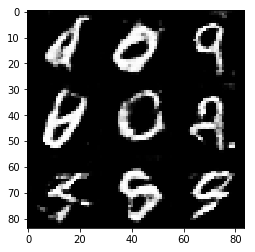

Epoch 2/2... Discriminator Loss: 0.5281... Generator Loss: 1.4284
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 2.0796... Generator Loss: 0.3495
Epoch 2/2... Discriminator Loss: 1.2604... Generator Loss: 0.4744
Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 1.1671
Epoch 2/2... Discriminator Loss: 0.6860... Generator Loss: 0.9389
Epoch 2/2... Discriminator Loss: 0.8980... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 2.1199... Generator Loss: 0.2159
Epoch 2/2... Discriminator Loss: 0.7266... Generator Loss: 1.0788
Epoch 2/2... Discriminator Loss: 0.7507... Generator Loss: 0.9649


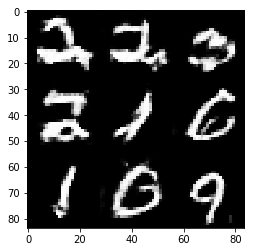

Epoch 2/2... Discriminator Loss: 1.6805... Generator Loss: 0.3847
Epoch 2/2... Discriminator Loss: 1.2975... Generator Loss: 0.4841
Epoch 2/2... Discriminator Loss: 0.4622... Generator Loss: 1.2949
Epoch 2/2... Discriminator Loss: 1.6299... Generator Loss: 0.4078
Epoch 2/2... Discriminator Loss: 0.7451... Generator Loss: 0.9970
Epoch 2/2... Discriminator Loss: 0.5470... Generator Loss: 1.7522
Epoch 2/2... Discriminator Loss: 1.3080... Generator Loss: 0.4270
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 0.5132... Generator Loss: 1.6221
Epoch 2/2... Discriminator Loss: 0.5017... Generator Loss: 1.1518


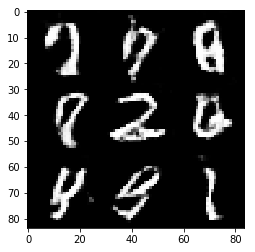

Epoch 2/2... Discriminator Loss: 0.7334... Generator Loss: 0.9574
Epoch 2/2... Discriminator Loss: 0.1168... Generator Loss: 2.6985
Epoch 2/2... Discriminator Loss: 0.3425... Generator Loss: 1.6545
Epoch 2/2... Discriminator Loss: 1.4463... Generator Loss: 0.5051
Epoch 2/2... Discriminator Loss: 0.5960... Generator Loss: 1.3292
Epoch 2/2... Discriminator Loss: 0.2611... Generator Loss: 2.6922
Epoch 2/2... Discriminator Loss: 3.2460... Generator Loss: 0.0985
Epoch 2/2... Discriminator Loss: 0.6378... Generator Loss: 1.3790
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.4461
Epoch 2/2... Discriminator Loss: 0.3700... Generator Loss: 1.6795


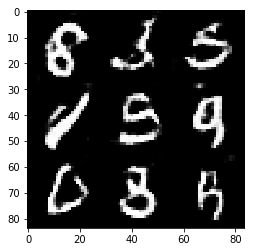

Epoch 2/2... Discriminator Loss: 0.7715... Generator Loss: 0.8927
Epoch 2/2... Discriminator Loss: 0.5910... Generator Loss: 1.1230
Epoch 2/2... Discriminator Loss: 0.4041... Generator Loss: 1.6466
Epoch 2/2... Discriminator Loss: 1.2424... Generator Loss: 0.5377
Epoch 2/2... Discriminator Loss: 0.3086... Generator Loss: 2.2118
Epoch 2/2... Discriminator Loss: 1.1105... Generator Loss: 0.5870
Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 0.7361
Epoch 2/2... Discriminator Loss: 0.8203... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 0.5596... Generator Loss: 1.3063
Epoch 2/2... Discriminator Loss: 0.6264... Generator Loss: 1.0995


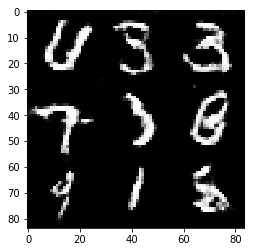

Epoch 2/2... Discriminator Loss: 0.5431... Generator Loss: 1.2723
Epoch 2/2... Discriminator Loss: 0.5250... Generator Loss: 1.2509
Epoch 2/2... Discriminator Loss: 0.4643... Generator Loss: 1.4268
Epoch 2/2... Discriminator Loss: 0.5778... Generator Loss: 1.1475
Epoch 2/2... Discriminator Loss: 0.6293... Generator Loss: 1.0841
Epoch 2/2... Discriminator Loss: 0.3735... Generator Loss: 1.4945
Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 0.9929
Epoch 2/2... Discriminator Loss: 0.4443... Generator Loss: 1.6180
Epoch 2/2... Discriminator Loss: 0.2723... Generator Loss: 2.3441
Epoch 2/2... Discriminator Loss: 1.1601... Generator Loss: 5.1700


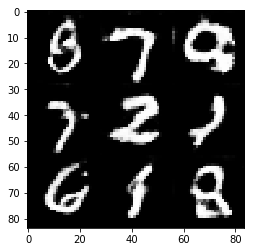

Epoch 2/2... Discriminator Loss: 0.3897... Generator Loss: 1.7637
Epoch 2/2... Discriminator Loss: 0.3807... Generator Loss: 1.8664
Epoch 2/2... Discriminator Loss: 0.4313... Generator Loss: 1.5337
Epoch 2/2... Discriminator Loss: 1.5021... Generator Loss: 4.3449
Epoch 2/2... Discriminator Loss: 0.6030... Generator Loss: 3.3493
Epoch 2/2... Discriminator Loss: 0.6066... Generator Loss: 2.9542
Epoch 2/2... Discriminator Loss: 0.6587... Generator Loss: 1.1518
Epoch 2/2... Discriminator Loss: 0.6101... Generator Loss: 1.2658
Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 0.6984... Generator Loss: 1.0765


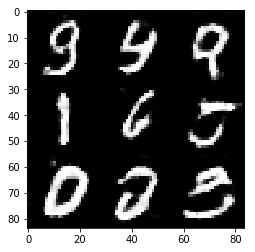

Epoch 2/2... Discriminator Loss: 0.5112... Generator Loss: 1.5802
Epoch 2/2... Discriminator Loss: 1.1647... Generator Loss: 0.5825
Epoch 2/2... Discriminator Loss: 0.6310... Generator Loss: 1.2360
Epoch 2/2... Discriminator Loss: 0.9941... Generator Loss: 0.7166
Epoch 2/2... Discriminator Loss: 0.6357... Generator Loss: 1.1171
Epoch 2/2... Discriminator Loss: 0.6226... Generator Loss: 1.0794
Epoch 2/2... Discriminator Loss: 0.5580... Generator Loss: 1.2442
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 0.5853
Epoch 2/2... Discriminator Loss: 0.5950... Generator Loss: 1.1436
Epoch 2/2... Discriminator Loss: 0.4606... Generator Loss: 1.5160


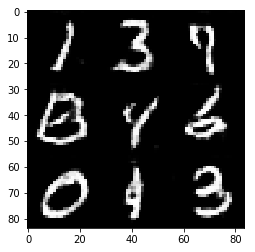

Epoch 2/2... Discriminator Loss: 0.8273... Generator Loss: 0.7981
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 0.6612
Epoch 2/2... Discriminator Loss: 0.6261... Generator Loss: 1.1769
Epoch 2/2... Discriminator Loss: 0.4115... Generator Loss: 1.8361
Epoch 2/2... Discriminator Loss: 0.4081... Generator Loss: 1.9946
Epoch 2/2... Discriminator Loss: 0.3775... Generator Loss: 1.9315
Epoch 2/2... Discriminator Loss: 0.4835... Generator Loss: 1.6015
Epoch 2/2... Discriminator Loss: 0.6651... Generator Loss: 2.8288
Epoch 2/2... Discriminator Loss: 1.0600... Generator Loss: 0.6350
Epoch 2/2... Discriminator Loss: 1.3459... Generator Loss: 0.4404


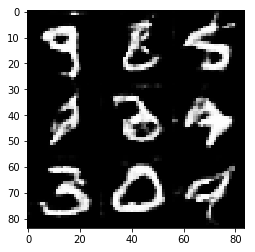

Epoch 2/2... Discriminator Loss: 0.2141... Generator Loss: 2.8458
Epoch 2/2... Discriminator Loss: 1.4519... Generator Loss: 0.4898
Epoch 2/2... Discriminator Loss: 0.4770... Generator Loss: 3.0095
Epoch 2/2... Discriminator Loss: 0.6374... Generator Loss: 1.2588
Epoch 2/2... Discriminator Loss: 0.7001... Generator Loss: 1.1190
Epoch 2/2... Discriminator Loss: 1.5095... Generator Loss: 0.4801
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 1.0386
Epoch 2/2... Discriminator Loss: 0.5067... Generator Loss: 1.4919
Epoch 2/2... Discriminator Loss: 0.2451... Generator Loss: 2.7128
Epoch 2/2... Discriminator Loss: 0.9404... Generator Loss: 0.8183


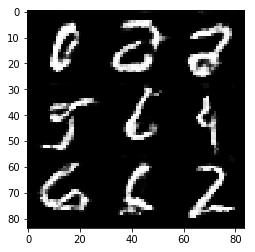

Epoch 2/2... Discriminator Loss: 1.1961... Generator Loss: 0.5092
Epoch 2/2... Discriminator Loss: 0.5993... Generator Loss: 1.3594
Epoch 2/2... Discriminator Loss: 0.4925... Generator Loss: 1.3134
Epoch 2/2... Discriminator Loss: 1.4036... Generator Loss: 0.4993
Epoch 2/2... Discriminator Loss: 0.7122... Generator Loss: 1.0743
Epoch 2/2... Discriminator Loss: 0.4345... Generator Loss: 2.6756
Epoch 2/2... Discriminator Loss: 0.5705... Generator Loss: 2.4267
Epoch 2/2... Discriminator Loss: 0.4715... Generator Loss: 2.4251
Epoch 2/2... Discriminator Loss: 0.4558... Generator Loss: 1.8391
Epoch 2/2... Discriminator Loss: 0.6782... Generator Loss: 1.0644


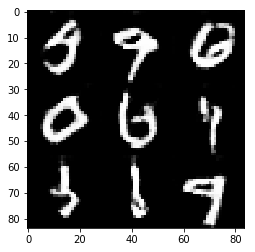

Epoch 2/2... Discriminator Loss: 0.6055... Generator Loss: 1.3197
Epoch 2/2... Discriminator Loss: 0.5717... Generator Loss: 1.2193
Epoch 2/2... Discriminator Loss: 0.6493... Generator Loss: 1.0130
Epoch 2/2... Discriminator Loss: 0.3855... Generator Loss: 1.7968
Epoch 2/2... Discriminator Loss: 0.6125... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 1.4716... Generator Loss: 0.3920
Epoch 2/2... Discriminator Loss: 0.4126... Generator Loss: 2.3661
Epoch 2/2... Discriminator Loss: 0.7903... Generator Loss: 0.8580
Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 1.3162
Epoch 2/2... Discriminator Loss: 0.4453... Generator Loss: 1.6234


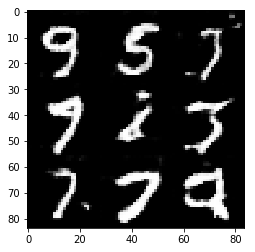

Epoch 2/2... Discriminator Loss: 0.7059... Generator Loss: 0.9816
Epoch 2/2... Discriminator Loss: 1.7938... Generator Loss: 0.4698
Epoch 2/2... Discriminator Loss: 0.4836... Generator Loss: 1.6388
Epoch 2/2... Discriminator Loss: 0.5899... Generator Loss: 1.1222
Epoch 2/2... Discriminator Loss: 0.6289... Generator Loss: 1.1768
Epoch 2/2... Discriminator Loss: 1.0722... Generator Loss: 0.6624
Epoch 2/2... Discriminator Loss: 0.6276... Generator Loss: 4.0437
Epoch 2/2... Discriminator Loss: 0.7821... Generator Loss: 0.8226
Epoch 2/2... Discriminator Loss: 0.4861... Generator Loss: 1.1758
Epoch 2/2... Discriminator Loss: 0.5076... Generator Loss: 1.4078


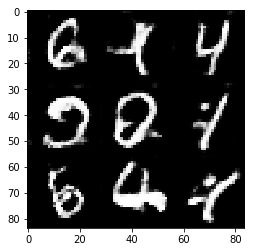

Epoch 2/2... Discriminator Loss: 0.5809... Generator Loss: 1.2335
Epoch 2/2... Discriminator Loss: 3.8228... Generator Loss: 0.0893
Epoch 2/2... Discriminator Loss: 1.1801... Generator Loss: 0.6613
Epoch 2/2... Discriminator Loss: 0.6153... Generator Loss: 1.7765
Epoch 2/2... Discriminator Loss: 1.2062... Generator Loss: 0.5753
Epoch 2/2... Discriminator Loss: 0.7131... Generator Loss: 2.4909
Epoch 2/2... Discriminator Loss: 0.5537... Generator Loss: 1.3905
Epoch 2/2... Discriminator Loss: 1.8045... Generator Loss: 0.3772
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 0.6569
Epoch 2/2... Discriminator Loss: 0.3224... Generator Loss: 1.8167


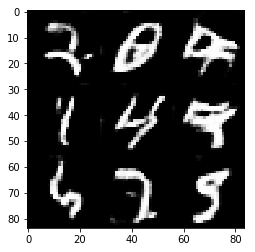

Epoch 2/2... Discriminator Loss: 0.4287... Generator Loss: 1.2869
Epoch 2/2... Discriminator Loss: 0.8877... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 1.4492... Generator Loss: 0.4818
Epoch 2/2... Discriminator Loss: 0.6147... Generator Loss: 1.4340
Epoch 2/2... Discriminator Loss: 0.4881... Generator Loss: 1.5801
Epoch 2/2... Discriminator Loss: 0.6456... Generator Loss: 1.2679
Epoch 2/2... Discriminator Loss: 0.6721... Generator Loss: 1.0088
Epoch 2/2... Discriminator Loss: 0.6595... Generator Loss: 1.1647
Epoch 2/2... Discriminator Loss: 0.2946... Generator Loss: 1.9010
Epoch 2/2... Discriminator Loss: 0.2586... Generator Loss: 2.0980


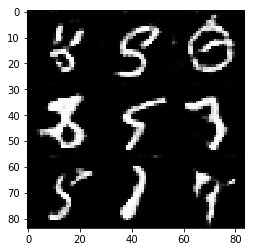

Epoch 2/2... Discriminator Loss: 0.5278... Generator Loss: 1.2729
Epoch 2/2... Discriminator Loss: 0.3761... Generator Loss: 1.8304
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 0.7930
Epoch 2/2... Discriminator Loss: 0.9179... Generator Loss: 0.6894
Epoch 2/2... Discriminator Loss: 0.3300... Generator Loss: 1.8424


In [35]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 7.8367
Epoch 1/1... Discriminator Loss: 0.1231... Generator Loss: 4.3829
Epoch 1/1... Discriminator Loss: 6.4415... Generator Loss: 0.0761
Epoch 1/1... Discriminator Loss: 1.9510... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.8051
Epoch 1/1... Discriminator Loss: 2.4392... Generator Loss: 0.2580
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.6161... Generator Loss: 0.3548
Epoch 1/1... Discriminator Loss: 0.7132... Generator Loss: 1.1654
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 2.6161


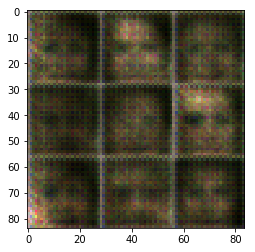

Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 2.4552... Generator Loss: 0.1554
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 2.1337
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.3980


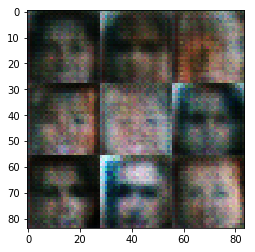

Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.4044
Epoch 1/1... Discriminator Loss: 0.6315... Generator Loss: 1.8243
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 2.9182... Generator Loss: 0.0676
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 1.4303
Epoch 1/1... Discriminator Loss: 0.6438... Generator Loss: 1.5429
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.7149... Generator Loss: 0.2615


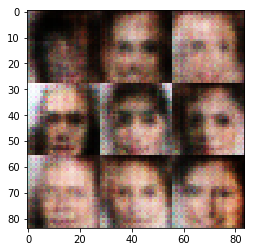

Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 2.1241... Generator Loss: 0.1522
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.9425... Generator Loss: 0.2726
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.8365... Generator Loss: 0.5612


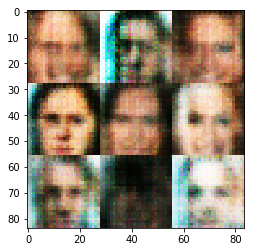

Epoch 1/1... Discriminator Loss: 1.7918... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.3423
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.3766
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 1.2176


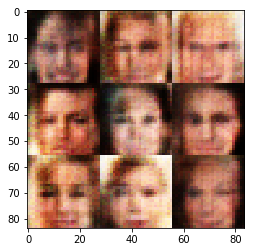

Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 1.1603
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 0.8469


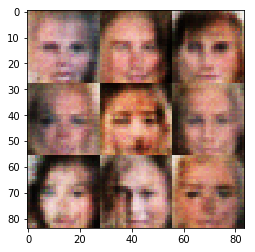

Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 1.2894
Epoch 1/1... Discriminator Loss: 1.8815... Generator Loss: 0.1997
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 0.6449... Generator Loss: 1.4711
Epoch 1/1... Discriminator Loss: 2.4508... Generator Loss: 0.2784
Epoch 1/1... Discriminator Loss: 1.6911... Generator Loss: 0.3060
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.5459
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.1442


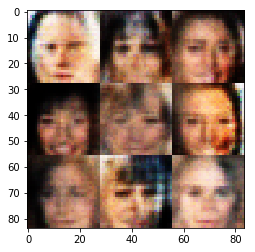

Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.6801... Generator Loss: 0.3121
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.3806
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.3679
Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.4819
Epoch 1/1... Discriminator Loss: 1.6349... Generator Loss: 2.6493
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 4.2043


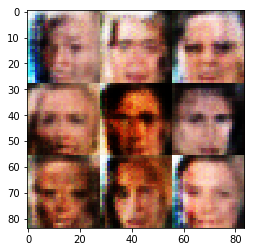

Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 0.2397... Generator Loss: 4.0166
Epoch 1/1... Discriminator Loss: 0.4228... Generator Loss: 6.1369
Epoch 1/1... Discriminator Loss: 0.1196... Generator Loss: 2.9735
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 0.1087... Generator Loss: 3.3009
Epoch 1/1... Discriminator Loss: 0.0907... Generator Loss: 3.3996
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.4571
Epoch 1/1... Discriminator Loss: 0.1378... Generator Loss: 6.0541
Epoch 1/1... Discriminator Loss: 0.0572... Generator Loss: 4.7949


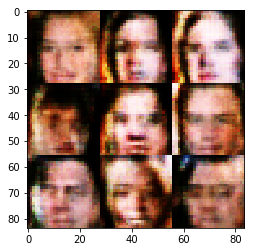

Epoch 1/1... Discriminator Loss: 0.0572... Generator Loss: 6.3345
Epoch 1/1... Discriminator Loss: 0.2116... Generator Loss: 2.0293
Epoch 1/1... Discriminator Loss: 0.0297... Generator Loss: 4.4938
Epoch 1/1... Discriminator Loss: 0.0301... Generator Loss: 4.9970
Epoch 1/1... Discriminator Loss: 0.1836... Generator Loss: 2.2195
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 3.5064
Epoch 1/1... Discriminator Loss: 0.1833... Generator Loss: 2.1086
Epoch 1/1... Discriminator Loss: 0.0573... Generator Loss: 4.5408
Epoch 1/1... Discriminator Loss: 0.0876... Generator Loss: 2.9550


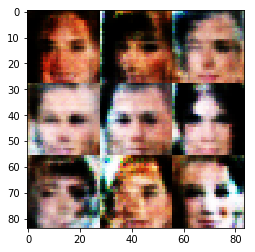

Epoch 1/1... Discriminator Loss: 0.1308... Generator Loss: 5.4635
Epoch 1/1... Discriminator Loss: 0.0729... Generator Loss: 3.4291
Epoch 1/1... Discriminator Loss: 0.0108... Generator Loss: 6.3194
Epoch 1/1... Discriminator Loss: 0.0236... Generator Loss: 5.1101
Epoch 1/1... Discriminator Loss: 0.0652... Generator Loss: 3.3329
Epoch 1/1... Discriminator Loss: 0.6072... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 0.0212... Generator Loss: 6.8950
Epoch 1/1... Discriminator Loss: 0.0400... Generator Loss: 4.4382
Epoch 1/1... Discriminator Loss: 0.1165... Generator Loss: 2.5198
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 1.2936


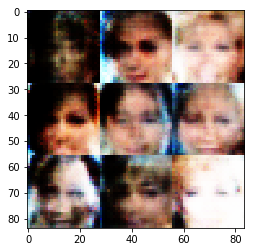

Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 1.3672
Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.3171
Epoch 1/1... Discriminator Loss: 0.2240... Generator Loss: 2.2440
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 3.4317
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 4.8602
Epoch 1/1... Discriminator Loss: 0.1069... Generator Loss: 3.1602
Epoch 1/1... Discriminator Loss: 0.2294... Generator Loss: 1.9419
Epoch 1/1... Discriminator Loss: 0.1012... Generator Loss: 5.9496
Epoch 1/1... Discriminator Loss: 0.0583... Generator Loss: 4.7048


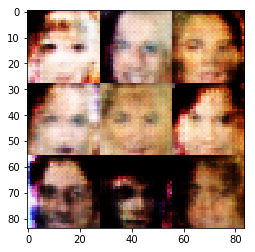

Epoch 1/1... Discriminator Loss: 0.0559... Generator Loss: 7.3212
Epoch 1/1... Discriminator Loss: 4.1101... Generator Loss: 0.0253
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 1.3815
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 1.1623
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 3.0633
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 1.1992
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 1.7787
Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 1.6102
Epoch 1/1... Discriminator Loss: 0.1046... Generator Loss: 5.9726


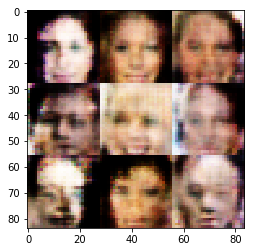

Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 1.5567
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 5.9677
Epoch 1/1... Discriminator Loss: 0.1324... Generator Loss: 7.0254
Epoch 1/1... Discriminator Loss: 0.0566... Generator Loss: 6.5037
Epoch 1/1... Discriminator Loss: 0.0096... Generator Loss: 6.8944
Epoch 1/1... Discriminator Loss: 0.2902... Generator Loss: 7.7603
Epoch 1/1... Discriminator Loss: 0.1202... Generator Loss: 6.1374
Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 6.6297
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 1.8929
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 6.9623


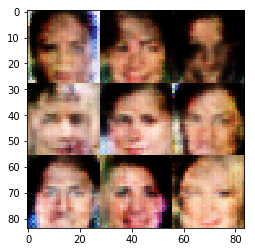

Epoch 1/1... Discriminator Loss: 0.0697... Generator Loss: 4.7333
Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 6.6674
Epoch 1/1... Discriminator Loss: 0.3057... Generator Loss: 1.6989
Epoch 1/1... Discriminator Loss: 0.1326... Generator Loss: 5.9894
Epoch 1/1... Discriminator Loss: 0.1147... Generator Loss: 2.4989
Epoch 1/1... Discriminator Loss: 0.1651... Generator Loss: 2.6493
Epoch 1/1... Discriminator Loss: 0.0399... Generator Loss: 4.8666
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.8776
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 0.3043... Generator Loss: 2.4267


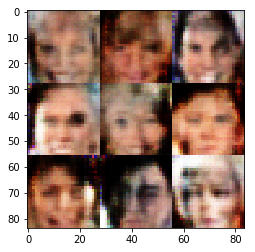

Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 1.2212
Epoch 1/1... Discriminator Loss: 0.4592... Generator Loss: 3.0430
Epoch 1/1... Discriminator Loss: 0.0254... Generator Loss: 4.3244
Epoch 1/1... Discriminator Loss: 0.2518... Generator Loss: 1.9719
Epoch 1/1... Discriminator Loss: 0.0863... Generator Loss: 3.1661
Epoch 1/1... Discriminator Loss: 0.0360... Generator Loss: 4.3312
Epoch 1/1... Discriminator Loss: 0.1639... Generator Loss: 2.4434
Epoch 1/1... Discriminator Loss: 3.7874... Generator Loss: 0.0399
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 3.2554
Epoch 1/1... Discriminator Loss: 0.1253... Generator Loss: 3.2353


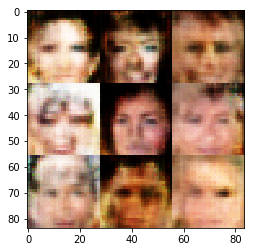

Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 3.9288
Epoch 1/1... Discriminator Loss: 0.2836... Generator Loss: 7.9771
Epoch 1/1... Discriminator Loss: 0.0343... Generator Loss: 4.3609
Epoch 1/1... Discriminator Loss: 0.0343... Generator Loss: 8.8136
Epoch 1/1... Discriminator Loss: 0.0356... Generator Loss: 7.6516
Epoch 1/1... Discriminator Loss: 5.2899... Generator Loss: 5.8662
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 1.5072
Epoch 1/1... Discriminator Loss: 0.1583... Generator Loss: 2.8222
Epoch 1/1... Discriminator Loss: 0.5284... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 0.2720... Generator Loss: 2.1642


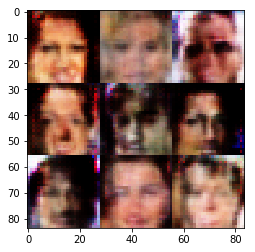

Epoch 1/1... Discriminator Loss: 0.3730... Generator Loss: 4.3854
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 0.2465... Generator Loss: 1.8375
Epoch 1/1... Discriminator Loss: 0.3284... Generator Loss: 6.1438
Epoch 1/1... Discriminator Loss: 1.7543... Generator Loss: 0.2669
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 0.1978... Generator Loss: 2.1256
Epoch 1/1... Discriminator Loss: 0.0887... Generator Loss: 3.5908
Epoch 1/1... Discriminator Loss: 0.1121... Generator Loss: 2.7282


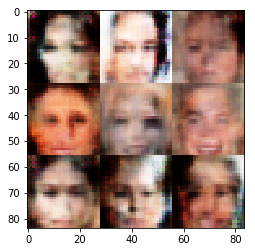

Epoch 1/1... Discriminator Loss: 0.0214... Generator Loss: 7.4791
Epoch 1/1... Discriminator Loss: 0.0637... Generator Loss: 4.4053
Epoch 1/1... Discriminator Loss: 2.6898... Generator Loss: 7.2848
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 1.7646
Epoch 1/1... Discriminator Loss: 0.1067... Generator Loss: 2.8933
Epoch 1/1... Discriminator Loss: 2.1895... Generator Loss: 0.1785
Epoch 1/1... Discriminator Loss: 0.0220... Generator Loss: 5.2301
Epoch 1/1... Discriminator Loss: 0.3490... Generator Loss: 1.3953
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 5.1164
Epoch 1/1... Discriminator Loss: 0.3197... Generator Loss: 3.2153


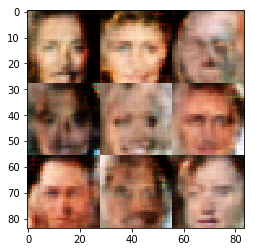

Epoch 1/1... Discriminator Loss: 0.2076... Generator Loss: 2.4923
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.3787
Epoch 1/1... Discriminator Loss: 0.0405... Generator Loss: 4.9640
Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 0.3172... Generator Loss: 2.5901
Epoch 1/1... Discriminator Loss: 0.0404... Generator Loss: 4.4494
Epoch 1/1... Discriminator Loss: 0.1195... Generator Loss: 2.3614
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 0.1908... Generator Loss: 1.9913


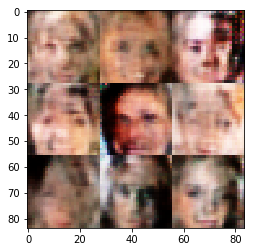

Epoch 1/1... Discriminator Loss: 0.0445... Generator Loss: 6.0048
Epoch 1/1... Discriminator Loss: 0.1312... Generator Loss: 2.3890
Epoch 1/1... Discriminator Loss: 0.1478... Generator Loss: 2.2502
Epoch 1/1... Discriminator Loss: 1.9953... Generator Loss: 0.2482
Epoch 1/1... Discriminator Loss: 0.3273... Generator Loss: 1.8397
Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 1.4949
Epoch 1/1... Discriminator Loss: 0.0914... Generator Loss: 5.4292
Epoch 1/1... Discriminator Loss: 0.3286... Generator Loss: 1.4633
Epoch 1/1... Discriminator Loss: 0.0251... Generator Loss: 6.9045
Epoch 1/1... Discriminator Loss: 0.1541... Generator Loss: 2.4149


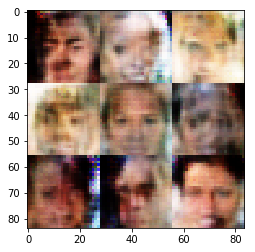

Epoch 1/1... Discriminator Loss: 2.0724... Generator Loss: 0.2509
Epoch 1/1... Discriminator Loss: 0.0665... Generator Loss: 3.6537
Epoch 1/1... Discriminator Loss: 0.0383... Generator Loss: 4.6522
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 0.2371... Generator Loss: 2.2667
Epoch 1/1... Discriminator Loss: 0.1055... Generator Loss: 5.2533
Epoch 1/1... Discriminator Loss: 0.1518... Generator Loss: 2.1848
Epoch 1/1... Discriminator Loss: 0.1187... Generator Loss: 5.1324
Epoch 1/1... Discriminator Loss: 0.1487... Generator Loss: 5.5300
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 1.0204


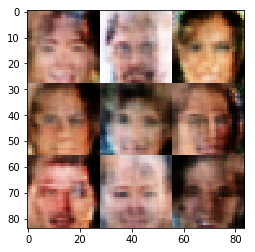

Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 1.2800
Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 3.9768
Epoch 1/1... Discriminator Loss: 0.0614... Generator Loss: 4.3017
Epoch 1/1... Discriminator Loss: 0.2259... Generator Loss: 1.8388
Epoch 1/1... Discriminator Loss: 1.8344... Generator Loss: 3.5927
Epoch 1/1... Discriminator Loss: 0.4281... Generator Loss: 1.6086
Epoch 1/1... Discriminator Loss: 0.3130... Generator Loss: 1.8819
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 5.8450
Epoch 1/1... Discriminator Loss: 2.6949... Generator Loss: 0.1048


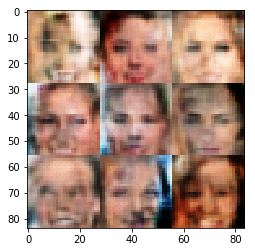

Epoch 1/1... Discriminator Loss: 0.0799... Generator Loss: 3.5821
Epoch 1/1... Discriminator Loss: 0.1662... Generator Loss: 2.1561
Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 6.5884
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 7.5465
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.2067
Epoch 1/1... Discriminator Loss: 0.0276... Generator Loss: 6.3601
Epoch 1/1... Discriminator Loss: 0.0871... Generator Loss: 5.0291
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 1.8785
Epoch 1/1... Discriminator Loss: 0.2444... Generator Loss: 4.6136
Epoch 1/1... Discriminator Loss: 0.0384... Generator Loss: 4.9032


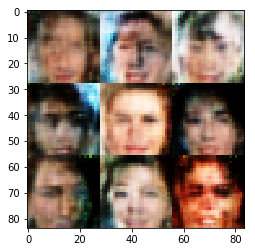

Epoch 1/1... Discriminator Loss: 0.4447... Generator Loss: 1.4023
Epoch 1/1... Discriminator Loss: 0.1540... Generator Loss: 3.6024
Epoch 1/1... Discriminator Loss: 0.1170... Generator Loss: 4.2997
Epoch 1/1... Discriminator Loss: 0.0715... Generator Loss: 5.0657
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 3.0068
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 3.2009
Epoch 1/1... Discriminator Loss: 0.0600... Generator Loss: 5.8217
Epoch 1/1... Discriminator Loss: 0.1591... Generator Loss: 2.4318
Epoch 1/1... Discriminator Loss: 0.0328... Generator Loss: 4.4352
Epoch 1/1... Discriminator Loss: 0.1013... Generator Loss: 2.6338


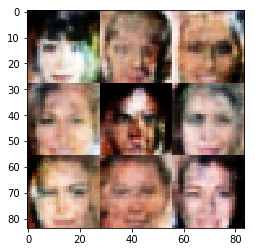

Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 4.0311
Epoch 1/1... Discriminator Loss: 0.0381... Generator Loss: 4.4940
Epoch 1/1... Discriminator Loss: 0.2082... Generator Loss: 3.0935
Epoch 1/1... Discriminator Loss: 0.1703... Generator Loss: 5.5464
Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 1.8527
Epoch 1/1... Discriminator Loss: 0.1045... Generator Loss: 3.1548
Epoch 1/1... Discriminator Loss: 0.0590... Generator Loss: 4.8151
Epoch 1/1... Discriminator Loss: 0.4144... Generator Loss: 1.5306
Epoch 1/1... Discriminator Loss: 0.5428... Generator Loss: 1.1939
Epoch 1/1... Discriminator Loss: 0.0753... Generator Loss: 3.2259


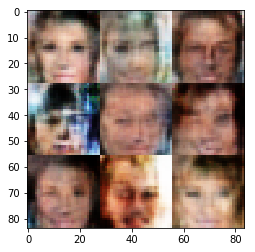

Epoch 1/1... Discriminator Loss: 0.3603... Generator Loss: 1.5797
Epoch 1/1... Discriminator Loss: 2.1727... Generator Loss: 0.1854
Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 4.4948
Epoch 1/1... Discriminator Loss: 0.0981... Generator Loss: 2.8361
Epoch 1/1... Discriminator Loss: 0.3579... Generator Loss: 1.7752
Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 1.8822... Generator Loss: 3.4637
Epoch 1/1... Discriminator Loss: 0.1210... Generator Loss: 2.4961
Epoch 1/1... Discriminator Loss: 0.0560... Generator Loss: 4.1060
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 4.2031


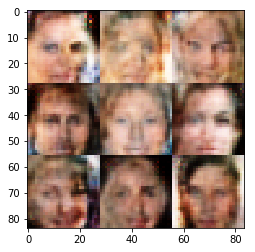

Epoch 1/1... Discriminator Loss: 0.0173... Generator Loss: 5.8120
Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 7.3096
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 0.1820... Generator Loss: 2.2758
Epoch 1/1... Discriminator Loss: 0.1567... Generator Loss: 6.0946
Epoch 1/1... Discriminator Loss: 0.1269... Generator Loss: 5.6830
Epoch 1/1... Discriminator Loss: 0.0327... Generator Loss: 4.7427
Epoch 1/1... Discriminator Loss: 0.1136... Generator Loss: 2.8615
Epoch 1/1... Discriminator Loss: 0.0814... Generator Loss: 4.0719
Epoch 1/1... Discriminator Loss: 0.0194... Generator Loss: 5.6584


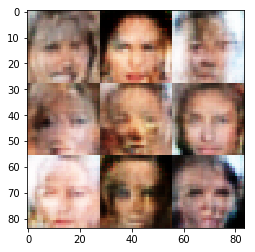

Epoch 1/1... Discriminator Loss: 1.7206... Generator Loss: 0.2638
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 2.1922
Epoch 1/1... Discriminator Loss: 0.1519... Generator Loss: 2.6850
Epoch 1/1... Discriminator Loss: 0.0653... Generator Loss: 3.3264
Epoch 1/1... Discriminator Loss: 0.2512... Generator Loss: 1.8857
Epoch 1/1... Discriminator Loss: 0.0612... Generator Loss: 3.5304
Epoch 1/1... Discriminator Loss: 4.5101... Generator Loss: 7.1217
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 1.1160
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 3.0242... Generator Loss: 0.0807


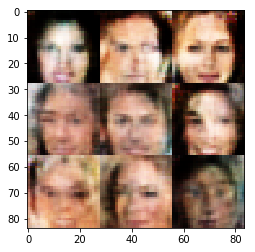

Epoch 1/1... Discriminator Loss: 0.1576... Generator Loss: 3.2602
Epoch 1/1... Discriminator Loss: 0.3529... Generator Loss: 4.8453
Epoch 1/1... Discriminator Loss: 0.1785... Generator Loss: 5.7326
Epoch 1/1... Discriminator Loss: 0.2443... Generator Loss: 7.4307
Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 1.5947
Epoch 1/1... Discriminator Loss: 0.0594... Generator Loss: 4.9206
Epoch 1/1... Discriminator Loss: 0.1667... Generator Loss: 6.3964
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 2.0807
Epoch 1/1... Discriminator Loss: 0.4606... Generator Loss: 1.4982


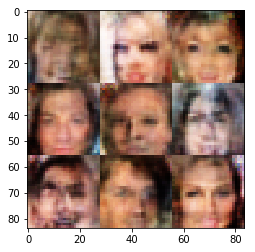

Epoch 1/1... Discriminator Loss: 0.4964... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.4821
Epoch 1/1... Discriminator Loss: 0.6688... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 0.1798... Generator Loss: 3.7080
Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 1.1970
Epoch 1/1... Discriminator Loss: 0.4723... Generator Loss: 4.5951
Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 5.0516
Epoch 1/1... Discriminator Loss: 0.1036... Generator Loss: 3.8020


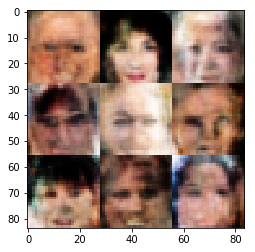

Epoch 1/1... Discriminator Loss: 0.0412... Generator Loss: 4.1494
Epoch 1/1... Discriminator Loss: 0.0780... Generator Loss: 6.2795
Epoch 1/1... Discriminator Loss: 0.3345... Generator Loss: 1.6893
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 2.3662
Epoch 1/1... Discriminator Loss: 0.2316... Generator Loss: 2.0010
Epoch 1/1... Discriminator Loss: 0.2771... Generator Loss: 1.9263
Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 2.6675
Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 1.4190
Epoch 1/1... Discriminator Loss: 0.1509... Generator Loss: 2.5506


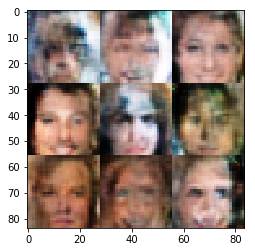

Epoch 1/1... Discriminator Loss: 0.0678... Generator Loss: 3.4663
Epoch 1/1... Discriminator Loss: 0.1523... Generator Loss: 2.6391
Epoch 1/1... Discriminator Loss: 0.0295... Generator Loss: 4.8933
Epoch 1/1... Discriminator Loss: 1.8658... Generator Loss: 0.4261
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 0.1549... Generator Loss: 4.2898
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 0.3122... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 0.4364... Generator Loss: 2.7869


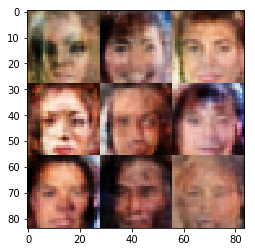

Epoch 1/1... Discriminator Loss: 0.2965... Generator Loss: 6.3800
Epoch 1/1... Discriminator Loss: 0.0391... Generator Loss: 3.9723
Epoch 1/1... Discriminator Loss: 0.0688... Generator Loss: 3.4372
Epoch 1/1... Discriminator Loss: 0.0513... Generator Loss: 6.6123
Epoch 1/1... Discriminator Loss: 0.1917... Generator Loss: 2.2609
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.3714
Epoch 1/1... Discriminator Loss: 0.1173... Generator Loss: 4.6833
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.6936


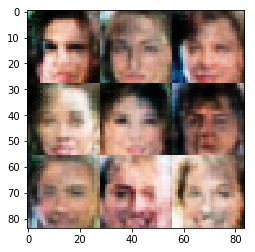

Epoch 1/1... Discriminator Loss: 0.1485... Generator Loss: 4.9683
Epoch 1/1... Discriminator Loss: 0.0465... Generator Loss: 5.7839
Epoch 1/1... Discriminator Loss: 0.0449... Generator Loss: 4.7703
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 6.5841
Epoch 1/1... Discriminator Loss: 0.0539... Generator Loss: 4.3714
Epoch 1/1... Discriminator Loss: 0.0506... Generator Loss: 4.8463
Epoch 1/1... Discriminator Loss: 0.3341... Generator Loss: 7.8224
Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 1.7391
Epoch 1/1... Discriminator Loss: 0.1994... Generator Loss: 2.0586
Epoch 1/1... Discriminator Loss: 0.3205... Generator Loss: 1.5456


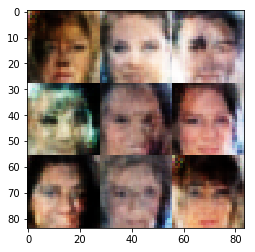

Epoch 1/1... Discriminator Loss: 0.0760... Generator Loss: 5.8731
Epoch 1/1... Discriminator Loss: 0.0765... Generator Loss: 3.9240
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 2.4605
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 1.2885
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.3829
Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 1.7131
Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 1.7253
Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 2.8586
Epoch 1/1... Discriminator Loss: 0.0490... Generator Loss: 4.5846
Epoch 1/1... Discriminator Loss: 3.0720... Generator Loss: 4.9778


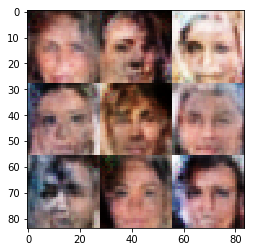

Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 0.2944... Generator Loss: 2.2726
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 2.7984
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 5.7103
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 3.3609
Epoch 1/1... Discriminator Loss: 0.1580... Generator Loss: 2.7957
Epoch 1/1... Discriminator Loss: 0.0397... Generator Loss: 4.4193
Epoch 1/1... Discriminator Loss: 0.0393... Generator Loss: 5.6691
Epoch 1/1... Discriminator Loss: 0.0323... Generator Loss: 5.1848
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6677


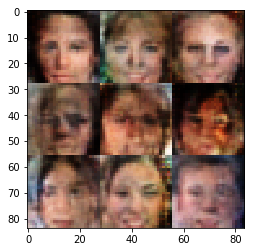

Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 1.5662
Epoch 1/1... Discriminator Loss: 0.3208... Generator Loss: 3.9072
Epoch 1/1... Discriminator Loss: 0.0455... Generator Loss: 3.9405
Epoch 1/1... Discriminator Loss: 0.5260... Generator Loss: 2.9855
Epoch 1/1... Discriminator Loss: 0.4459... Generator Loss: 1.5415
Epoch 1/1... Discriminator Loss: 0.0924... Generator Loss: 3.3390
Epoch 1/1... Discriminator Loss: 0.0630... Generator Loss: 5.2662
Epoch 1/1... Discriminator Loss: 0.0442... Generator Loss: 3.8534
Epoch 1/1... Discriminator Loss: 0.0680... Generator Loss: 6.8815
Epoch 1/1... Discriminator Loss: 0.0164... Generator Loss: 5.3230


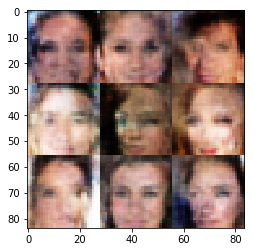

Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.2259
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 0.5419... Generator Loss: 1.3532
Epoch 1/1... Discriminator Loss: 0.1544... Generator Loss: 4.6519
Epoch 1/1... Discriminator Loss: 0.3756... Generator Loss: 1.4480
Epoch 1/1... Discriminator Loss: 0.0772... Generator Loss: 3.5987
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 1.4236
Epoch 1/1... Discriminator Loss: 3.0348... Generator Loss: 0.1632
Epoch 1/1... Discriminator Loss: 0.2473... Generator Loss: 1.9823
Epoch 1/1... Discriminator Loss: 0.1072... Generator Loss: 2.8380


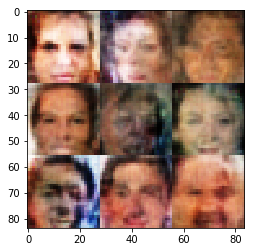

Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 3.2838
Epoch 1/1... Discriminator Loss: 0.0955... Generator Loss: 3.3777
Epoch 1/1... Discriminator Loss: 3.2406... Generator Loss: 4.9417
Epoch 1/1... Discriminator Loss: 0.2525... Generator Loss: 2.1661
Epoch 1/1... Discriminator Loss: 0.1938... Generator Loss: 2.5416
Epoch 1/1... Discriminator Loss: 0.2626... Generator Loss: 1.9927
Epoch 1/1... Discriminator Loss: 0.0854... Generator Loss: 4.8149
Epoch 1/1... Discriminator Loss: 0.4536... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 0.1442... Generator Loss: 2.4350
Epoch 1/1... Discriminator Loss: 0.0542... Generator Loss: 4.1693


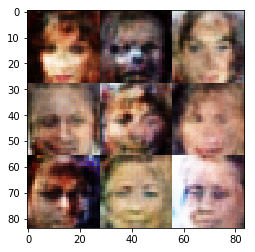

Epoch 1/1... Discriminator Loss: 0.4883... Generator Loss: 2.9675
Epoch 1/1... Discriminator Loss: 0.0979... Generator Loss: 2.8611
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 4.3121
Epoch 1/1... Discriminator Loss: 0.0626... Generator Loss: 3.9852
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.3667
Epoch 1/1... Discriminator Loss: 0.1557... Generator Loss: 2.6801
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 5.0498
Epoch 1/1... Discriminator Loss: 0.2027... Generator Loss: 2.6616
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 1.5626
Epoch 1/1... Discriminator Loss: 0.0487... Generator Loss: 5.2707


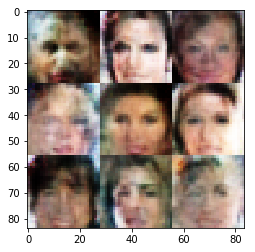

Epoch 1/1... Discriminator Loss: 0.5011... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 0.3156... Generator Loss: 3.7926
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 4.4157
Epoch 1/1... Discriminator Loss: 0.0462... Generator Loss: 5.5032
Epoch 1/1... Discriminator Loss: 0.0878... Generator Loss: 3.1068
Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 1.1996
Epoch 1/1... Discriminator Loss: 0.6952... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 5.0277
Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 1.6216
Epoch 1/1... Discriminator Loss: 0.3097... Generator Loss: 2.2489


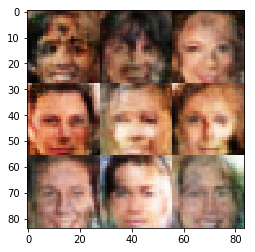

Epoch 1/1... Discriminator Loss: 0.0372... Generator Loss: 6.3639
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 0.1872... Generator Loss: 6.4862
Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 3.8741
Epoch 1/1... Discriminator Loss: 0.2972... Generator Loss: 1.8517
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 2.2095
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 0.0672... Generator Loss: 3.5280
Epoch 1/1... Discriminator Loss: 0.2107... Generator Loss: 2.2748
Epoch 1/1... Discriminator Loss: 0.0555... Generator Loss: 4.7191


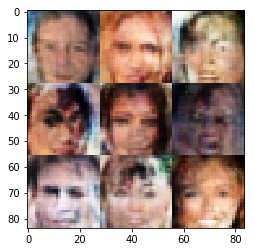

Epoch 1/1... Discriminator Loss: 0.0825... Generator Loss: 3.2939
Epoch 1/1... Discriminator Loss: 1.7491... Generator Loss: 0.3674
Epoch 1/1... Discriminator Loss: 0.0604... Generator Loss: 6.6269
Epoch 1/1... Discriminator Loss: 0.2297... Generator Loss: 2.0673
Epoch 1/1... Discriminator Loss: 0.0289... Generator Loss: 5.9819
Epoch 1/1... Discriminator Loss: 1.6840... Generator Loss: 6.1667
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 0.1155... Generator Loss: 3.1000
Epoch 1/1... Discriminator Loss: 0.1649... Generator Loss: 2.6036
Epoch 1/1... Discriminator Loss: 0.0823... Generator Loss: 3.3479


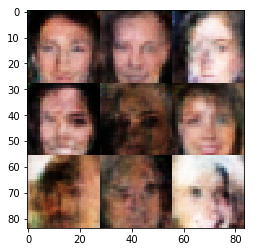

Epoch 1/1... Discriminator Loss: 0.2769... Generator Loss: 7.3669
Epoch 1/1... Discriminator Loss: 0.0260... Generator Loss: 4.9262
Epoch 1/1... Discriminator Loss: 0.0384... Generator Loss: 6.8997
Epoch 1/1... Discriminator Loss: 0.0252... Generator Loss: 4.6901
Epoch 1/1... Discriminator Loss: 2.4478... Generator Loss: 6.4454
Epoch 1/1... Discriminator Loss: 0.1666... Generator Loss: 2.1663
Epoch 1/1... Discriminator Loss: 0.1255... Generator Loss: 2.8286
Epoch 1/1... Discriminator Loss: 0.2941... Generator Loss: 1.8437
Epoch 1/1... Discriminator Loss: 0.0670... Generator Loss: 5.7055
Epoch 1/1... Discriminator Loss: 0.0305... Generator Loss: 4.5308


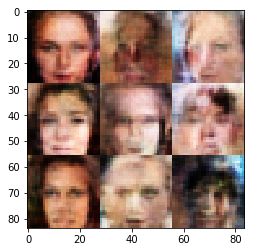

Epoch 1/1... Discriminator Loss: 0.0769... Generator Loss: 4.3543
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 0.0309... Generator Loss: 5.8303
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.1343
Epoch 1/1... Discriminator Loss: 0.2064... Generator Loss: 3.7941
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 0.1726... Generator Loss: 2.4698
Epoch 1/1... Discriminator Loss: 0.1605... Generator Loss: 2.2880
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 2.0835
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 0.9895


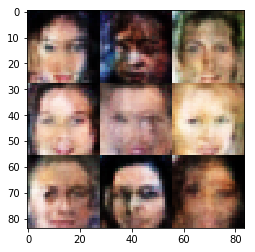

Epoch 1/1... Discriminator Loss: 0.1414... Generator Loss: 4.2077
Epoch 1/1... Discriminator Loss: 2.0502... Generator Loss: 8.2897
Epoch 1/1... Discriminator Loss: 0.1901... Generator Loss: 2.3631
Epoch 1/1... Discriminator Loss: 0.1588... Generator Loss: 2.6316
Epoch 1/1... Discriminator Loss: 0.2007... Generator Loss: 2.2556
Epoch 1/1... Discriminator Loss: 0.0522... Generator Loss: 6.0948
Epoch 1/1... Discriminator Loss: 0.0319... Generator Loss: 6.8804
Epoch 1/1... Discriminator Loss: 0.0820... Generator Loss: 2.9878
Epoch 1/1... Discriminator Loss: 0.0411... Generator Loss: 5.3420
Epoch 1/1... Discriminator Loss: 0.0365... Generator Loss: 5.8349


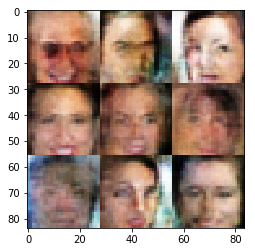

Epoch 1/1... Discriminator Loss: 0.1479... Generator Loss: 2.5718
Epoch 1/1... Discriminator Loss: 0.0664... Generator Loss: 4.7243
Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 4.9486
Epoch 1/1... Discriminator Loss: 0.0355... Generator Loss: 6.4635
Epoch 1/1... Discriminator Loss: 0.0616... Generator Loss: 3.3971
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 0.1405... Generator Loss: 2.4378
Epoch 1/1... Discriminator Loss: 0.0640... Generator Loss: 4.6939
Epoch 1/1... Discriminator Loss: 0.0437... Generator Loss: 4.2034
Epoch 1/1... Discriminator Loss: 0.0383... Generator Loss: 6.5737


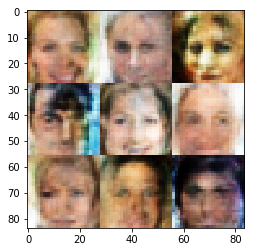

Epoch 1/1... Discriminator Loss: 0.1124... Generator Loss: 6.3701
Epoch 1/1... Discriminator Loss: 0.0813... Generator Loss: 3.3432
Epoch 1/1... Discriminator Loss: 0.0803... Generator Loss: 3.0934
Epoch 1/1... Discriminator Loss: 2.6219... Generator Loss: 0.1610
Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 1.4494
Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 4.5974
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.4938
Epoch 1/1... Discriminator Loss: 0.4296... Generator Loss: 1.4466
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 3.5911
Epoch 1/1... Discriminator Loss: 0.6172... Generator Loss: 1.2337


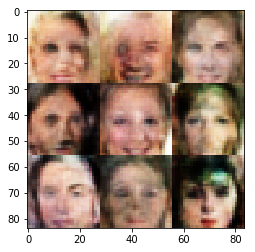

Epoch 1/1... Discriminator Loss: 0.0405... Generator Loss: 4.6478
Epoch 1/1... Discriminator Loss: 0.1290... Generator Loss: 3.2426
Epoch 1/1... Discriminator Loss: 0.4734... Generator Loss: 4.8447
Epoch 1/1... Discriminator Loss: 0.2834... Generator Loss: 2.6533
Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 5.5509
Epoch 1/1... Discriminator Loss: 0.2465... Generator Loss: 1.9528
Epoch 1/1... Discriminator Loss: 0.0233... Generator Loss: 6.6298
Epoch 1/1... Discriminator Loss: 0.5341... Generator Loss: 3.3042
Epoch 1/1... Discriminator Loss: 0.4598... Generator Loss: 2.4529
Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 1.3308


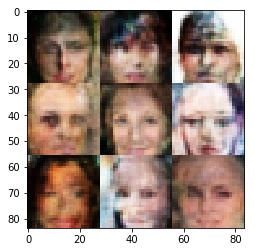

Epoch 1/1... Discriminator Loss: 0.1246... Generator Loss: 3.5677
Epoch 1/1... Discriminator Loss: 0.0744... Generator Loss: 3.4841
Epoch 1/1... Discriminator Loss: 0.5208... Generator Loss: 1.1097
Epoch 1/1... Discriminator Loss: 0.7177... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 0.6870... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 0.2392... Generator Loss: 2.1016
Epoch 1/1... Discriminator Loss: 0.0462... Generator Loss: 6.8327
Epoch 1/1... Discriminator Loss: 0.3120... Generator Loss: 3.5323
Epoch 1/1... Discriminator Loss: 0.0378... Generator Loss: 4.4825
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 5.2427


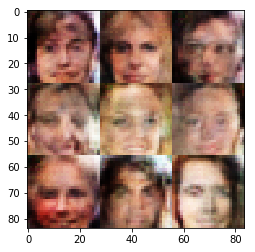

Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 1.6412
Epoch 1/1... Discriminator Loss: 0.2516... Generator Loss: 2.9080
Epoch 1/1... Discriminator Loss: 0.1524... Generator Loss: 3.4910
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 0.0592... Generator Loss: 3.7138
Epoch 1/1... Discriminator Loss: 4.2904... Generator Loss: 7.5840
Epoch 1/1... Discriminator Loss: 0.6906... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 1.8811


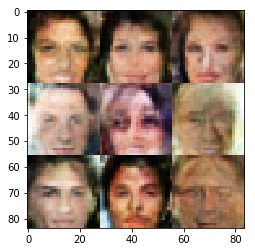

Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.3360
Epoch 1/1... Discriminator Loss: 0.2018... Generator Loss: 2.4068
Epoch 1/1... Discriminator Loss: 0.0462... Generator Loss: 3.8578
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 0.1337... Generator Loss: 2.8257
Epoch 1/1... Discriminator Loss: 2.8498... Generator Loss: 0.1024
Epoch 1/1... Discriminator Loss: 0.0466... Generator Loss: 5.4533
Epoch 1/1... Discriminator Loss: 0.1419... Generator Loss: 2.7853
Epoch 1/1... Discriminator Loss: 0.0560... Generator Loss: 5.1738
Epoch 1/1... Discriminator Loss: 0.0758... Generator Loss: 3.8444


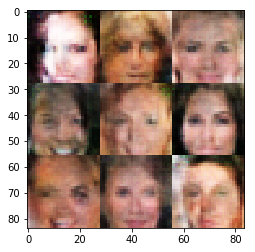

Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 5.1076
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 1.4909
Epoch 1/1... Discriminator Loss: 0.1486... Generator Loss: 3.1179
Epoch 1/1... Discriminator Loss: 0.0831... Generator Loss: 3.6735
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 1.6318
Epoch 1/1... Discriminator Loss: 0.1595... Generator Loss: 2.3062
Epoch 1/1... Discriminator Loss: 0.0819... Generator Loss: 3.3851
Epoch 1/1... Discriminator Loss: 0.0412... Generator Loss: 4.2064


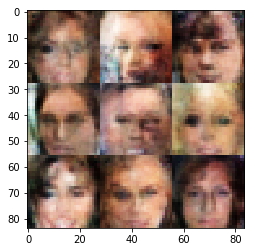

Epoch 1/1... Discriminator Loss: 0.0791... Generator Loss: 3.7471
Epoch 1/1... Discriminator Loss: 0.0792... Generator Loss: 3.4716
Epoch 1/1... Discriminator Loss: 0.0501... Generator Loss: 4.0744
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 0.0658... Generator Loss: 3.2919
Epoch 1/1... Discriminator Loss: 0.0838... Generator Loss: 3.1669
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 0.4048... Generator Loss: 1.2436
Epoch 1/1... Discriminator Loss: 0.0937... Generator Loss: 3.1611
Epoch 1/1... Discriminator Loss: 0.0076... Generator Loss: 5.8258


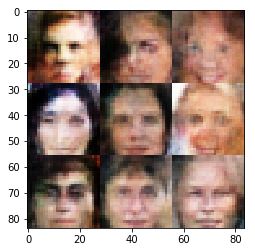

Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 4.9044
Epoch 1/1... Discriminator Loss: 0.2864... Generator Loss: 1.7073
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 4.5871
Epoch 1/1... Discriminator Loss: 0.1253... Generator Loss: 3.1736
Epoch 1/1... Discriminator Loss: 0.2166... Generator Loss: 2.3389
Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 2.3249
Epoch 1/1... Discriminator Loss: 0.2449... Generator Loss: 2.9052
Epoch 1/1... Discriminator Loss: 0.3438... Generator Loss: 2.5018
Epoch 1/1... Discriminator Loss: 0.3201... Generator Loss: 2.0465


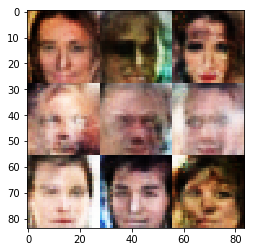

Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 0.1865... Generator Loss: 2.2917
Epoch 1/1... Discriminator Loss: 0.1082... Generator Loss: 3.0213
Epoch 1/1... Discriminator Loss: 0.2668... Generator Loss: 1.8992
Epoch 1/1... Discriminator Loss: 0.0357... Generator Loss: 4.3024
Epoch 1/1... Discriminator Loss: 0.0231... Generator Loss: 4.9940
Epoch 1/1... Discriminator Loss: 0.0703... Generator Loss: 3.8747
Epoch 1/1... Discriminator Loss: 0.1991... Generator Loss: 2.3244
Epoch 1/1... Discriminator Loss: 0.1078... Generator Loss: 2.7091
Epoch 1/1... Discriminator Loss: 0.1587... Generator Loss: 2.5995


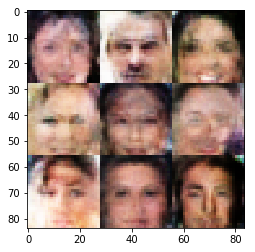

Epoch 1/1... Discriminator Loss: 0.0632... Generator Loss: 4.5024
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 7.8836
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 0.2987... Generator Loss: 1.7084
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 1.3951
Epoch 1/1... Discriminator Loss: 0.1204... Generator Loss: 2.9054
Epoch 1/1... Discriminator Loss: 0.0803... Generator Loss: 3.0173
Epoch 1/1... Discriminator Loss: 0.3164... Generator Loss: 1.8606


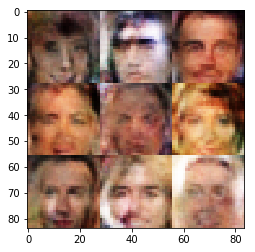

Epoch 1/1... Discriminator Loss: 0.1468... Generator Loss: 3.4387
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 0.3958... Generator Loss: 1.2975
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 1.5579
Epoch 1/1... Discriminator Loss: 0.0265... Generator Loss: 4.3548
Epoch 1/1... Discriminator Loss: 0.0606... Generator Loss: 3.8536
Epoch 1/1... Discriminator Loss: 0.2394... Generator Loss: 1.9495
Epoch 1/1... Discriminator Loss: 0.0278... Generator Loss: 7.4580
Epoch 1/1... Discriminator Loss: 0.0832... Generator Loss: 5.3094
Epoch 1/1... Discriminator Loss: 0.0882... Generator Loss: 5.6463


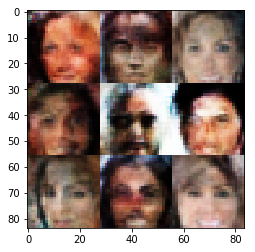

Epoch 1/1... Discriminator Loss: 0.0321... Generator Loss: 5.6059
Epoch 1/1... Discriminator Loss: 0.0110... Generator Loss: 5.8795
Epoch 1/1... Discriminator Loss: 0.1087... Generator Loss: 4.4546
Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 4.0583
Epoch 1/1... Discriminator Loss: 0.0782... Generator Loss: 4.5132
Epoch 1/1... Discriminator Loss: 0.2393... Generator Loss: 1.9620
Epoch 1/1... Discriminator Loss: 0.0533... Generator Loss: 3.6109
Epoch 1/1... Discriminator Loss: 0.1017... Generator Loss: 3.0239
Epoch 1/1... Discriminator Loss: 0.0318... Generator Loss: 6.8659
Epoch 1/1... Discriminator Loss: 0.0180... Generator Loss: 7.0468


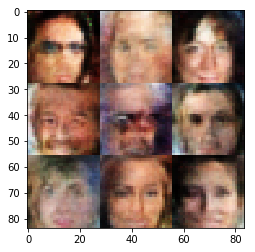

Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 5.7477
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 3.2801
Epoch 1/1... Discriminator Loss: 0.0343... Generator Loss: 6.0096
Epoch 1/1... Discriminator Loss: 0.1926... Generator Loss: 2.1647
Epoch 1/1... Discriminator Loss: 0.2291... Generator Loss: 6.0402
Epoch 1/1... Discriminator Loss: 4.2200... Generator Loss: 8.7705
Epoch 1/1... Discriminator Loss: 0.3334... Generator Loss: 2.1785
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 0.3330... Generator Loss: 1.7194
Epoch 1/1... Discriminator Loss: 0.2757... Generator Loss: 4.2363


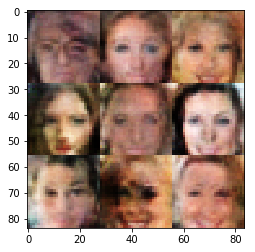

Epoch 1/1... Discriminator Loss: 0.0467... Generator Loss: 5.6743
Epoch 1/1... Discriminator Loss: 0.0582... Generator Loss: 3.8943
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.3156
Epoch 1/1... Discriminator Loss: 0.1003... Generator Loss: 3.2725
Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 5.4254
Epoch 1/1... Discriminator Loss: 0.0808... Generator Loss: 3.3185
Epoch 1/1... Discriminator Loss: 2.1886... Generator Loss: 6.6626
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 0.3049... Generator Loss: 1.9077
Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 0.9860


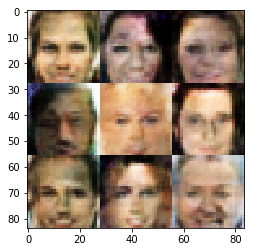

Epoch 1/1... Discriminator Loss: 0.4800... Generator Loss: 1.3460
Epoch 1/1... Discriminator Loss: 0.4812... Generator Loss: 1.5796
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 4.5187
Epoch 1/1... Discriminator Loss: 0.1203... Generator Loss: 3.3604
Epoch 1/1... Discriminator Loss: 0.0786... Generator Loss: 3.2521
Epoch 1/1... Discriminator Loss: 0.2623... Generator Loss: 2.1851
Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 3.9222
Epoch 1/1... Discriminator Loss: 0.0768... Generator Loss: 3.5824
Epoch 1/1... Discriminator Loss: 0.0804... Generator Loss: 4.2722


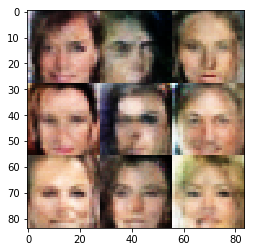

Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 3.2884
Epoch 1/1... Discriminator Loss: 0.3071... Generator Loss: 1.6567
Epoch 1/1... Discriminator Loss: 0.0781... Generator Loss: 3.1477
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 4.1334
Epoch 1/1... Discriminator Loss: 0.3736... Generator Loss: 1.6783
Epoch 1/1... Discriminator Loss: 0.0977... Generator Loss: 2.8881
Epoch 1/1... Discriminator Loss: 0.0282... Generator Loss: 4.5389
Epoch 1/1... Discriminator Loss: 0.0546... Generator Loss: 4.5175
Epoch 1/1... Discriminator Loss: 0.1948... Generator Loss: 2.0131
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 7.4798


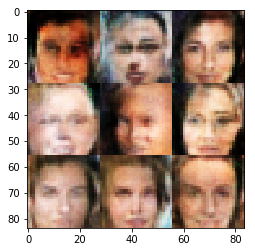

Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.4028
Epoch 1/1... Discriminator Loss: 0.0623... Generator Loss: 6.0999
Epoch 1/1... Discriminator Loss: 0.0388... Generator Loss: 4.0825
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 0.0252... Generator Loss: 6.4455
Epoch 1/1... Discriminator Loss: 0.3012... Generator Loss: 1.9681
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 0.3831... Generator Loss: 1.6926
Epoch 1/1... Discriminator Loss: 0.2274... Generator Loss: 4.8524
Epoch 1/1... Discriminator Loss: 3.4703... Generator Loss: 8.1701


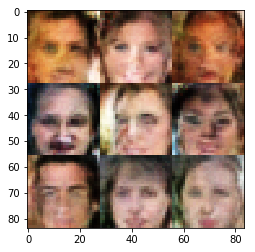

Epoch 1/1... Discriminator Loss: 0.2500... Generator Loss: 3.1288
Epoch 1/1... Discriminator Loss: 0.7808... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 0.2193... Generator Loss: 2.2939
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 2.3114... Generator Loss: 0.1302
Epoch 1/1... Discriminator Loss: 0.0402... Generator Loss: 3.9311
Epoch 1/1... Discriminator Loss: 0.2213... Generator Loss: 7.9244
Epoch 1/1... Discriminator Loss: 0.0307... Generator Loss: 3.9223
Epoch 1/1... Discriminator Loss: 0.0833... Generator Loss: 2.9057


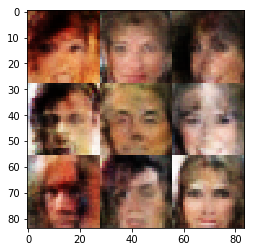

Epoch 1/1... Discriminator Loss: 0.1999... Generator Loss: 2.3633
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 1.6686
Epoch 1/1... Discriminator Loss: 0.0563... Generator Loss: 3.4680
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 1.2605
Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 4.1663
Epoch 1/1... Discriminator Loss: 0.0262... Generator Loss: 6.4689
Epoch 1/1... Discriminator Loss: 0.0716... Generator Loss: 3.5032
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.4283
Epoch 1/1... Discriminator Loss: 0.1922... Generator Loss: 3.7701
Epoch 1/1... Discriminator Loss: 0.2207... Generator Loss: 1.9308


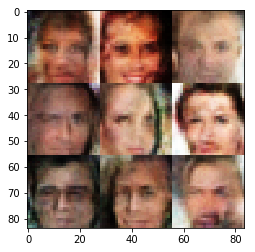

Epoch 1/1... Discriminator Loss: 0.0808... Generator Loss: 3.7107
Epoch 1/1... Discriminator Loss: 0.0387... Generator Loss: 6.5574
Epoch 1/1... Discriminator Loss: 0.4097... Generator Loss: 1.4226
Epoch 1/1... Discriminator Loss: 0.0308... Generator Loss: 4.4614
Epoch 1/1... Discriminator Loss: 0.0530... Generator Loss: 3.7458
Epoch 1/1... Discriminator Loss: 0.0366... Generator Loss: 4.8364
Epoch 1/1... Discriminator Loss: 0.0415... Generator Loss: 4.4573
Epoch 1/1... Discriminator Loss: 0.0301... Generator Loss: 5.0226
Epoch 1/1... Discriminator Loss: 0.3073... Generator Loss: 1.7113
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 6.3577


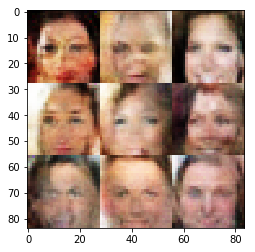

Epoch 1/1... Discriminator Loss: 0.0258... Generator Loss: 4.3659
Epoch 1/1... Discriminator Loss: 0.0957... Generator Loss: 3.1230
Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 1.4383
Epoch 1/1... Discriminator Loss: 0.1703... Generator Loss: 2.5234
Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 3.0406
Epoch 1/1... Discriminator Loss: 0.0732... Generator Loss: 3.4624
Epoch 1/1... Discriminator Loss: 0.1676... Generator Loss: 6.2794
Epoch 1/1... Discriminator Loss: 0.2058... Generator Loss: 2.4101
Epoch 1/1... Discriminator Loss: 0.1109... Generator Loss: 4.9692
Epoch 1/1... Discriminator Loss: 0.0362... Generator Loss: 3.8961


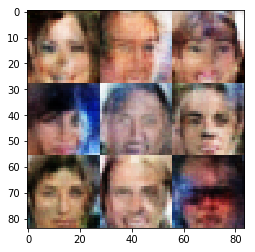

Epoch 1/1... Discriminator Loss: 0.0455... Generator Loss: 4.0038
Epoch 1/1... Discriminator Loss: 0.1693... Generator Loss: 2.3595
Epoch 1/1... Discriminator Loss: 0.0495... Generator Loss: 4.6450
Epoch 1/1... Discriminator Loss: 0.0340... Generator Loss: 3.8741
Epoch 1/1... Discriminator Loss: 0.1055... Generator Loss: 2.7781
Epoch 1/1... Discriminator Loss: 0.0171... Generator Loss: 5.3602
Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 7.9574
Epoch 1/1... Discriminator Loss: 0.0209... Generator Loss: 6.6661
Epoch 1/1... Discriminator Loss: 0.1369... Generator Loss: 2.4772
Epoch 1/1... Discriminator Loss: 0.2846... Generator Loss: 1.8338


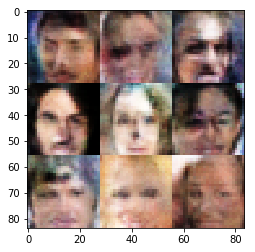

Epoch 1/1... Discriminator Loss: 0.0061... Generator Loss: 6.5152
Epoch 1/1... Discriminator Loss: 0.0101... Generator Loss: 6.5557
Epoch 1/1... Discriminator Loss: 0.0332... Generator Loss: 4.6970
Epoch 1/1... Discriminator Loss: 0.0048... Generator Loss: 7.8477
Epoch 1/1... Discriminator Loss: 0.0267... Generator Loss: 9.9100
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 5.6986
Epoch 1/1... Discriminator Loss: 0.0511... Generator Loss: 3.3211
Epoch 1/1... Discriminator Loss: 0.0322... Generator Loss: 4.0184
Epoch 1/1... Discriminator Loss: 0.0095... Generator Loss: 5.7383
Epoch 1/1... Discriminator Loss: 1.7891... Generator Loss: 10.7484


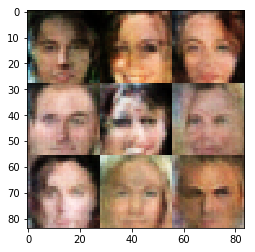

Epoch 1/1... Discriminator Loss: 0.1202... Generator Loss: 2.5555
Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 6.8997
Epoch 1/1... Discriminator Loss: 0.0673... Generator Loss: 3.7100
Epoch 1/1... Discriminator Loss: 0.2322... Generator Loss: 2.2588
Epoch 1/1... Discriminator Loss: 0.0106... Generator Loss: 6.2688
Epoch 1/1... Discriminator Loss: 0.0142... Generator Loss: 6.9901
Epoch 1/1... Discriminator Loss: 0.0774... Generator Loss: 5.3661
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 6.9783
Epoch 1/1... Discriminator Loss: 1.6127... Generator Loss: 0.3805


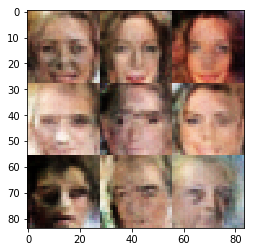

Epoch 1/1... Discriminator Loss: 1.9448... Generator Loss: 0.4787
Epoch 1/1... Discriminator Loss: 0.0939... Generator Loss: 4.3277
Epoch 1/1... Discriminator Loss: 0.0467... Generator Loss: 4.1926
Epoch 1/1... Discriminator Loss: 0.1306... Generator Loss: 2.8662
Epoch 1/1... Discriminator Loss: 0.0979... Generator Loss: 4.0973
Epoch 1/1... Discriminator Loss: 3.0640... Generator Loss: 5.9474
Epoch 1/1... Discriminator Loss: 0.1458... Generator Loss: 2.6147
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 6.9625
Epoch 1/1... Discriminator Loss: 0.2908... Generator Loss: 4.2690
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6487


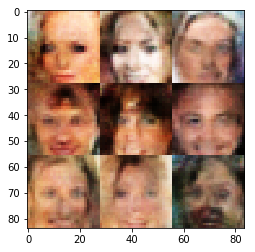

Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 0.1645... Generator Loss: 3.4715
Epoch 1/1... Discriminator Loss: 0.0361... Generator Loss: 4.2632
Epoch 1/1... Discriminator Loss: 0.0983... Generator Loss: 2.9626
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.9753
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 5.5202
Epoch 1/1... Discriminator Loss: 0.1665... Generator Loss: 2.7192
Epoch 1/1... Discriminator Loss: 0.0680... Generator Loss: 3.7908
Epoch 1/1... Discriminator Loss: 0.1227... Generator Loss: 2.7389
Epoch 1/1... Discriminator Loss: 1.8065... Generator Loss: 6.9286


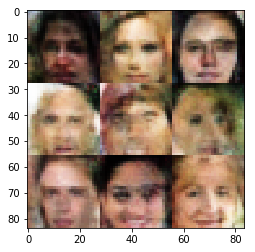

Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 1.5737
Epoch 1/1... Discriminator Loss: 0.0425... Generator Loss: 3.9651
Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 0.1476... Generator Loss: 2.7627
Epoch 1/1... Discriminator Loss: 0.2850... Generator Loss: 1.8785
Epoch 1/1... Discriminator Loss: 0.0290... Generator Loss: 3.9560
Epoch 1/1... Discriminator Loss: 0.0488... Generator Loss: 3.6929
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 1.5254
Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 1.0858


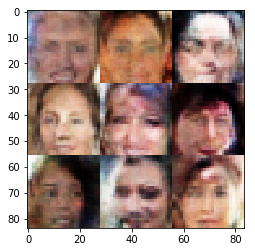

Epoch 1/1... Discriminator Loss: 0.0519... Generator Loss: 6.0488
Epoch 1/1... Discriminator Loss: 0.0353... Generator Loss: 5.0812
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 0.0197... Generator Loss: 4.8823
Epoch 1/1... Discriminator Loss: 0.1348... Generator Loss: 3.1267
Epoch 1/1... Discriminator Loss: 0.0244... Generator Loss: 6.4225
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 0.1398... Generator Loss: 3.4722
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 4.5388
Epoch 1/1... Discriminator Loss: 0.5647... Generator Loss: 1.4940


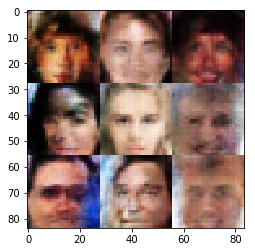

Epoch 1/1... Discriminator Loss: 0.4233... Generator Loss: 1.2813
Epoch 1/1... Discriminator Loss: 0.3000... Generator Loss: 2.0037
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 0.3110... Generator Loss: 1.6850
Epoch 1/1... Discriminator Loss: 0.2439... Generator Loss: 2.4063
Epoch 1/1... Discriminator Loss: 0.3198... Generator Loss: 1.8710
Epoch 1/1... Discriminator Loss: 0.2244... Generator Loss: 2.3443
Epoch 1/1... Discriminator Loss: 0.0153... Generator Loss: 5.3699
Epoch 1/1... Discriminator Loss: 0.1797... Generator Loss: 2.3285
Epoch 1/1... Discriminator Loss: 0.0320... Generator Loss: 3.9758


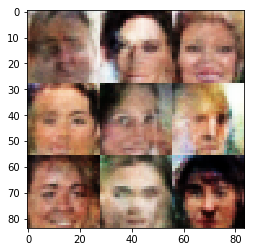

Epoch 1/1... Discriminator Loss: 0.6244... Generator Loss: 4.0905
Epoch 1/1... Discriminator Loss: 3.0639... Generator Loss: 0.1185
Epoch 1/1... Discriminator Loss: 0.0778... Generator Loss: 3.6861
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.2285
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 0.2142... Generator Loss: 3.6303
Epoch 1/1... Discriminator Loss: 0.0320... Generator Loss: 5.3527
Epoch 1/1... Discriminator Loss: 0.0614... Generator Loss: 3.7146
Epoch 1/1... Discriminator Loss: 0.0322... Generator Loss: 5.0342
Epoch 1/1... Discriminator Loss: 0.0693... Generator Loss: 3.7984


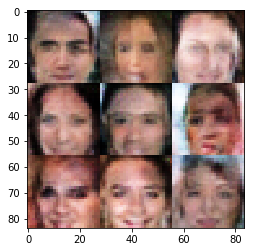

Epoch 1/1... Discriminator Loss: 0.2311... Generator Loss: 1.9916
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.4730
Epoch 1/1... Discriminator Loss: 0.1477... Generator Loss: 3.2434
Epoch 1/1... Discriminator Loss: 3.7430... Generator Loss: 0.0822
Epoch 1/1... Discriminator Loss: 0.1398... Generator Loss: 3.8169
Epoch 1/1... Discriminator Loss: 0.1481... Generator Loss: 2.9506
Epoch 1/1... Discriminator Loss: 0.0632... Generator Loss: 3.6323
Epoch 1/1... Discriminator Loss: 0.1491... Generator Loss: 2.8779
Epoch 1/1... Discriminator Loss: 0.0393... Generator Loss: 3.9100
Epoch 1/1... Discriminator Loss: 0.3444... Generator Loss: 4.1304


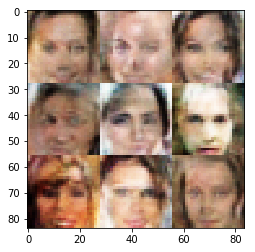

Epoch 1/1... Discriminator Loss: 0.2068... Generator Loss: 3.1133
Epoch 1/1... Discriminator Loss: 0.1283... Generator Loss: 3.3768
Epoch 1/1... Discriminator Loss: 0.1633... Generator Loss: 2.6029
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 1.6869
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 4.6125
Epoch 1/1... Discriminator Loss: 0.1697... Generator Loss: 2.3593
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.0395
Epoch 1/1... Discriminator Loss: 0.0367... Generator Loss: 5.1278
Epoch 1/1... Discriminator Loss: 0.0711... Generator Loss: 4.4492
Epoch 1/1... Discriminator Loss: 0.0768... Generator Loss: 5.5991


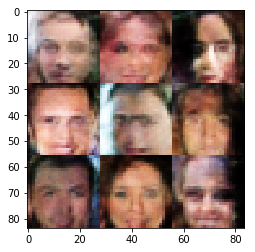

Epoch 1/1... Discriminator Loss: 0.0795... Generator Loss: 5.1391
Epoch 1/1... Discriminator Loss: 0.1414... Generator Loss: 2.5098
Epoch 1/1... Discriminator Loss: 0.0438... Generator Loss: 4.0350
Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 5.6965
Epoch 1/1... Discriminator Loss: 0.0366... Generator Loss: 4.4546
Epoch 1/1... Discriminator Loss: 0.1752... Generator Loss: 2.2174
Epoch 1/1... Discriminator Loss: 0.5337... Generator Loss: 1.4896
Epoch 1/1... Discriminator Loss: 0.2553... Generator Loss: 2.0097
Epoch 1/1... Discriminator Loss: 0.0870... Generator Loss: 3.1600
Epoch 1/1... Discriminator Loss: 0.3346... Generator Loss: 1.5495


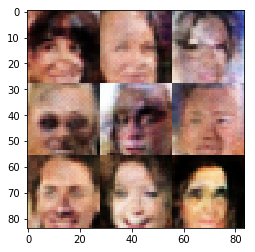

Epoch 1/1... Discriminator Loss: 0.0323... Generator Loss: 4.4732
Epoch 1/1... Discriminator Loss: 0.1767... Generator Loss: 2.3904
Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 1.5814
Epoch 1/1... Discriminator Loss: 0.4930... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 0.1552... Generator Loss: 2.4845
Epoch 1/1... Discriminator Loss: 0.0593... Generator Loss: 3.7675
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 0.1324... Generator Loss: 2.6854
Epoch 1/1... Discriminator Loss: 0.0712... Generator Loss: 3.5144
Epoch 1/1... Discriminator Loss: 1.7512... Generator Loss: 0.3280


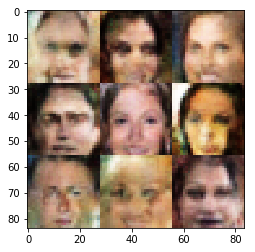

Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.1475
Epoch 1/1... Discriminator Loss: 0.2929... Generator Loss: 2.4253
Epoch 1/1... Discriminator Loss: 0.1010... Generator Loss: 3.0938
Epoch 1/1... Discriminator Loss: 0.1235... Generator Loss: 2.9843
Epoch 1/1... Discriminator Loss: 0.0344... Generator Loss: 5.7384
Epoch 1/1... Discriminator Loss: 0.0646... Generator Loss: 3.3871
Epoch 1/1... Discriminator Loss: 0.0823... Generator Loss: 3.3740
Epoch 1/1... Discriminator Loss: 0.0882... Generator Loss: 3.1647
Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 1.4003
Epoch 1/1... Discriminator Loss: 0.0417... Generator Loss: 4.8154


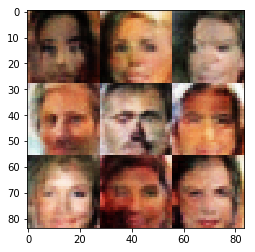

Epoch 1/1... Discriminator Loss: 0.1567... Generator Loss: 2.5259
Epoch 1/1... Discriminator Loss: 0.0428... Generator Loss: 5.4878
Epoch 1/1... Discriminator Loss: 0.0149... Generator Loss: 5.3622
Epoch 1/1... Discriminator Loss: 2.4051... Generator Loss: 0.1202
Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 2.7130
Epoch 1/1... Discriminator Loss: 0.1869... Generator Loss: 2.3118
Epoch 1/1... Discriminator Loss: 0.0108... Generator Loss: 7.4955
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 3.3093
Epoch 1/1... Discriminator Loss: 0.1783... Generator Loss: 3.6137
Epoch 1/1... Discriminator Loss: 0.3010... Generator Loss: 1.9615


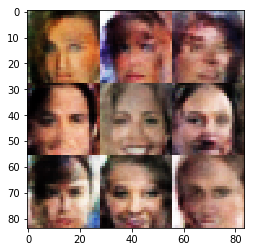

Epoch 1/1... Discriminator Loss: 0.0380... Generator Loss: 4.5684
Epoch 1/1... Discriminator Loss: 0.1767... Generator Loss: 3.0466
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 2.7083
Epoch 1/1... Discriminator Loss: 0.2752... Generator Loss: 2.0358
Epoch 1/1... Discriminator Loss: 2.3616... Generator Loss: 0.4009
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 0.1310... Generator Loss: 2.6802
Epoch 1/1... Discriminator Loss: 0.0698... Generator Loss: 3.5439
Epoch 1/1... Discriminator Loss: 0.0671... Generator Loss: 3.2996
Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 1.4744


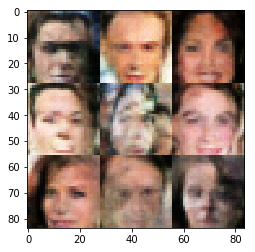

Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 0.0623... Generator Loss: 4.5977
Epoch 1/1... Discriminator Loss: 0.1424... Generator Loss: 2.4060
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 1.0507
Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 3.2444
Epoch 1/1... Discriminator Loss: 0.1080... Generator Loss: 2.8548
Epoch 1/1... Discriminator Loss: 2.9430... Generator Loss: 0.1216
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 4.5809
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 0.1909... Generator Loss: 2.6197


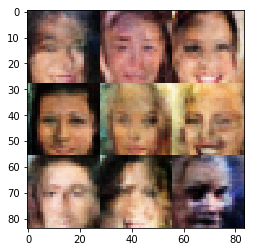

Epoch 1/1... Discriminator Loss: 0.5608... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 0.1350... Generator Loss: 2.6316
Epoch 1/1... Discriminator Loss: 0.2159... Generator Loss: 2.1333
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 1.6598
Epoch 1/1... Discriminator Loss: 0.4046... Generator Loss: 1.6759
Epoch 1/1... Discriminator Loss: 0.0798... Generator Loss: 4.4426
Epoch 1/1... Discriminator Loss: 0.2560... Generator Loss: 2.0655
Epoch 1/1... Discriminator Loss: 0.0834... Generator Loss: 3.2812
Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 1.5705
Epoch 1/1... Discriminator Loss: 0.1505... Generator Loss: 2.3463


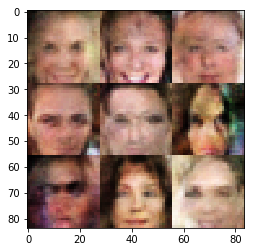

Epoch 1/1... Discriminator Loss: 0.4964... Generator Loss: 5.6036
Epoch 1/1... Discriminator Loss: 0.1933... Generator Loss: 2.4544
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 5.9301
Epoch 1/1... Discriminator Loss: 0.2479... Generator Loss: 1.9070
Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 5.0834
Epoch 1/1... Discriminator Loss: 0.0230... Generator Loss: 4.7230
Epoch 1/1... Discriminator Loss: 0.4634... Generator Loss: 1.4892
Epoch 1/1... Discriminator Loss: 0.0116... Generator Loss: 5.9897
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 4.1428


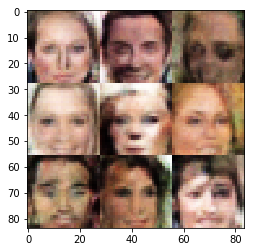

Epoch 1/1... Discriminator Loss: 0.0134... Generator Loss: 5.5707
Epoch 1/1... Discriminator Loss: 0.2105... Generator Loss: 1.9366
Epoch 1/1... Discriminator Loss: 0.1849... Generator Loss: 2.1352
Epoch 1/1... Discriminator Loss: 0.0959... Generator Loss: 3.4120
Epoch 1/1... Discriminator Loss: 0.1251... Generator Loss: 3.0546
Epoch 1/1... Discriminator Loss: 0.2949... Generator Loss: 2.1297
Epoch 1/1... Discriminator Loss: 4.1446... Generator Loss: 0.0580
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 0.0214... Generator Loss: 5.8832
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 1.2144


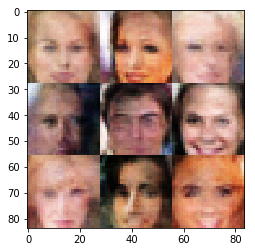

Epoch 1/1... Discriminator Loss: 2.0486... Generator Loss: 0.2310
Epoch 1/1... Discriminator Loss: 0.2258... Generator Loss: 2.5427
Epoch 1/1... Discriminator Loss: 0.3544... Generator Loss: 2.0148
Epoch 1/1... Discriminator Loss: 1.8896... Generator Loss: 0.4045
Epoch 1/1... Discriminator Loss: 0.0612... Generator Loss: 3.2797
Epoch 1/1... Discriminator Loss: 0.0964... Generator Loss: 3.5486
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 2.5762
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 0.2028... Generator Loss: 2.3485
Epoch 1/1... Discriminator Loss: 0.1683... Generator Loss: 2.5414


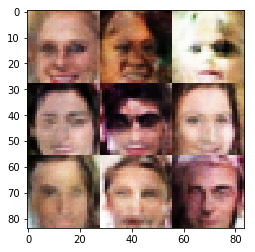

Epoch 1/1... Discriminator Loss: 0.2139... Generator Loss: 2.0144
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 0.1302... Generator Loss: 2.4316
Epoch 1/1... Discriminator Loss: 0.2342... Generator Loss: 2.1690
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 0.1180... Generator Loss: 2.6314
Epoch 1/1... Discriminator Loss: 0.0789... Generator Loss: 4.4398
Epoch 1/1... Discriminator Loss: 0.1781... Generator Loss: 3.0173
Epoch 1/1... Discriminator Loss: 0.0375... Generator Loss: 4.3435
Epoch 1/1... Discriminator Loss: 0.0597... Generator Loss: 5.4468


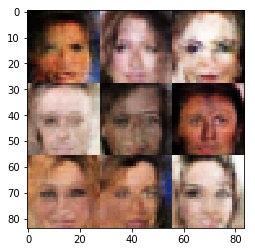

Epoch 1/1... Discriminator Loss: 3.2714... Generator Loss: 0.0553
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 0.3098... Generator Loss: 2.0134
Epoch 1/1... Discriminator Loss: 0.1013... Generator Loss: 3.6812
Epoch 1/1... Discriminator Loss: 0.1795... Generator Loss: 2.6499
Epoch 1/1... Discriminator Loss: 0.0593... Generator Loss: 3.7653
Epoch 1/1... Discriminator Loss: 0.0172... Generator Loss: 5.0641
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 0.0120... Generator Loss: 6.0430
Epoch 1/1... Discriminator Loss: 0.0903... Generator Loss: 3.5604


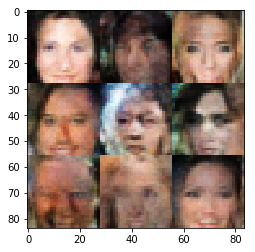

Epoch 1/1... Discriminator Loss: 0.0203... Generator Loss: 5.4014
Epoch 1/1... Discriminator Loss: 0.4819... Generator Loss: 1.7319
Epoch 1/1... Discriminator Loss: 0.0425... Generator Loss: 4.2543
Epoch 1/1... Discriminator Loss: 0.0909... Generator Loss: 3.0211
Epoch 1/1... Discriminator Loss: 0.0681... Generator Loss: 3.2808
Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 0.0448... Generator Loss: 3.9453
Epoch 1/1... Discriminator Loss: 0.1727... Generator Loss: 2.7573
Epoch 1/1... Discriminator Loss: 0.0445... Generator Loss: 4.2940
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 5.3404


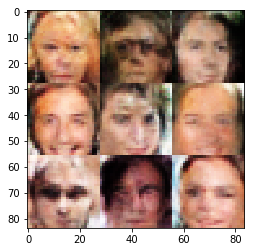

Epoch 1/1... Discriminator Loss: 2.1839... Generator Loss: 0.2345
Epoch 1/1... Discriminator Loss: 0.0716... Generator Loss: 3.3289
Epoch 1/1... Discriminator Loss: 0.1542... Generator Loss: 2.8801
Epoch 1/1... Discriminator Loss: 0.2477... Generator Loss: 1.7693
Epoch 1/1... Discriminator Loss: 0.0207... Generator Loss: 5.8328
Epoch 1/1... Discriminator Loss: 0.0504... Generator Loss: 3.9994
Epoch 1/1... Discriminator Loss: 0.2424... Generator Loss: 2.9912
Epoch 1/1... Discriminator Loss: 0.2382... Generator Loss: 1.9185
Epoch 1/1... Discriminator Loss: 0.0162... Generator Loss: 5.8807
Epoch 1/1... Discriminator Loss: 0.0219... Generator Loss: 5.6450


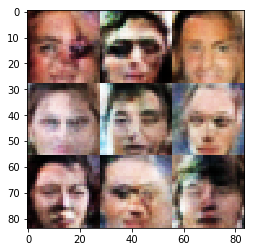

Epoch 1/1... Discriminator Loss: 0.0461... Generator Loss: 4.9171
Epoch 1/1... Discriminator Loss: 0.3453... Generator Loss: 4.6657
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 1.2527
Epoch 1/1... Discriminator Loss: 0.2458... Generator Loss: 2.0621
Epoch 1/1... Discriminator Loss: 0.0501... Generator Loss: 4.0224
Epoch 1/1... Discriminator Loss: 0.1178... Generator Loss: 2.8421
Epoch 1/1... Discriminator Loss: 0.4254... Generator Loss: 1.3582
Epoch 1/1... Discriminator Loss: 0.0775... Generator Loss: 3.4833
Epoch 1/1... Discriminator Loss: 2.9043... Generator Loss: 0.3121
Epoch 1/1... Discriminator Loss: 0.2124... Generator Loss: 2.4702


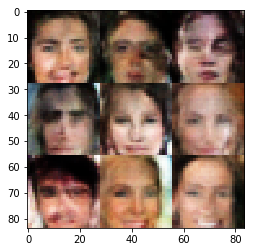

Epoch 1/1... Discriminator Loss: 0.1983... Generator Loss: 2.5412
Epoch 1/1... Discriminator Loss: 0.4700... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 0.4714... Generator Loss: 1.7520
Epoch 1/1... Discriminator Loss: 0.0327... Generator Loss: 5.2085
Epoch 1/1... Discriminator Loss: 0.0562... Generator Loss: 4.8396
Epoch 1/1... Discriminator Loss: 0.4198... Generator Loss: 1.8579
Epoch 1/1... Discriminator Loss: 0.0637... Generator Loss: 3.3869
Epoch 1/1... Discriminator Loss: 0.0209... Generator Loss: 5.1980
Epoch 1/1... Discriminator Loss: 0.1673... Generator Loss: 2.7861
Epoch 1/1... Discriminator Loss: 0.0418... Generator Loss: 5.2027


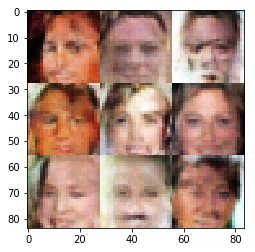

Epoch 1/1... Discriminator Loss: 0.5796... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 0.0396... Generator Loss: 4.2584
Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 4.6379
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 1.3164
Epoch 1/1... Discriminator Loss: 0.0414... Generator Loss: 4.1832
Epoch 1/1... Discriminator Loss: 0.2724... Generator Loss: 2.0433
Epoch 1/1... Discriminator Loss: 0.0303... Generator Loss: 5.6228
Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 0.1061... Generator Loss: 3.3333


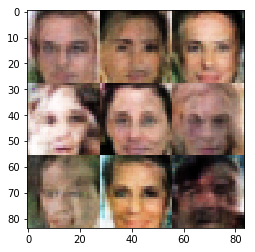

Epoch 1/1... Discriminator Loss: 0.0109... Generator Loss: 5.7560
Epoch 1/1... Discriminator Loss: 0.1663... Generator Loss: 2.3792
Epoch 1/1... Discriminator Loss: 0.0548... Generator Loss: 3.8389
Epoch 1/1... Discriminator Loss: 0.1641... Generator Loss: 2.4679
Epoch 1/1... Discriminator Loss: 0.2325... Generator Loss: 2.1200
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 0.0247... Generator Loss: 6.8519
Epoch 1/1... Discriminator Loss: 1.8698... Generator Loss: 5.4908
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 0.0664... Generator Loss: 3.8880


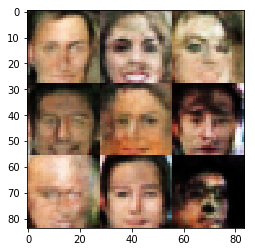

Epoch 1/1... Discriminator Loss: 0.0153... Generator Loss: 5.9282
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 0.2672... Generator Loss: 3.2714
Epoch 1/1... Discriminator Loss: 0.1295... Generator Loss: 2.5519
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 1.2622
Epoch 1/1... Discriminator Loss: 0.1567... Generator Loss: 6.3863
Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 1.2878
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 0.4712... Generator Loss: 1.5813


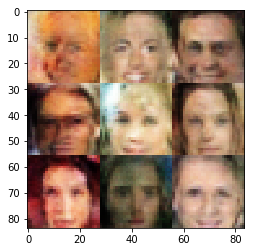

Epoch 1/1... Discriminator Loss: 0.1029... Generator Loss: 3.7414
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 1.2546
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 3.0024
Epoch 1/1... Discriminator Loss: 0.2661... Generator Loss: 2.0259
Epoch 1/1... Discriminator Loss: 0.1139... Generator Loss: 3.7535
Epoch 1/1... Discriminator Loss: 0.2409... Generator Loss: 2.0468
Epoch 1/1... Discriminator Loss: 0.3100... Generator Loss: 2.2270
Epoch 1/1... Discriminator Loss: 2.8056... Generator Loss: 0.1404
Epoch 1/1... Discriminator Loss: 0.0937... Generator Loss: 5.0257
Epoch 1/1... Discriminator Loss: 0.0654... Generator Loss: 4.0081


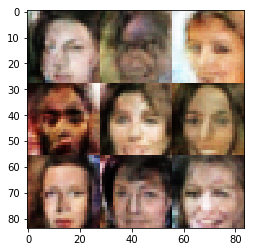

Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 0.4834... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 0.2122... Generator Loss: 2.4782
Epoch 1/1... Discriminator Loss: 0.0659... Generator Loss: 3.3987
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 2.5206
Epoch 1/1... Discriminator Loss: 0.4474... Generator Loss: 1.3011
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 3.0691... Generator Loss: 0.0664
Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 1.5051
Epoch 1/1... Discriminator Loss: 0.0775... Generator Loss: 3.7116


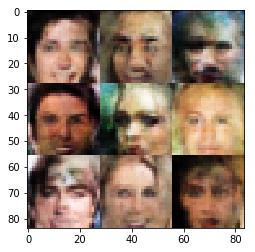

Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 1.5173
Epoch 1/1... Discriminator Loss: 0.2438... Generator Loss: 6.8870
Epoch 1/1... Discriminator Loss: 2.2370... Generator Loss: 0.1752
Epoch 1/1... Discriminator Loss: 0.0656... Generator Loss: 4.5049
Epoch 1/1... Discriminator Loss: 0.1282... Generator Loss: 3.2160
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 0.4605... Generator Loss: 1.5026
Epoch 1/1... Discriminator Loss: 0.1506... Generator Loss: 2.8722
Epoch 1/1... Discriminator Loss: 0.0167... Generator Loss: 5.2357
Epoch 1/1... Discriminator Loss: 0.0402... Generator Loss: 7.5689


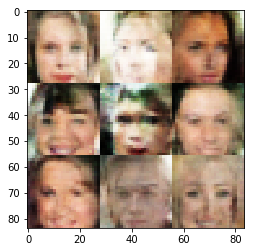

Epoch 1/1... Discriminator Loss: 0.0356... Generator Loss: 4.7777
Epoch 1/1... Discriminator Loss: 1.8660... Generator Loss: 0.2244
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 5.9187
Epoch 1/1... Discriminator Loss: 0.0096... Generator Loss: 6.1235
Epoch 1/1... Discriminator Loss: 0.0959... Generator Loss: 2.9716
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 5.0835
Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 1.8478
Epoch 1/1... Discriminator Loss: 0.2863... Generator Loss: 1.9380
Epoch 1/1... Discriminator Loss: 0.0747... Generator Loss: 3.2253


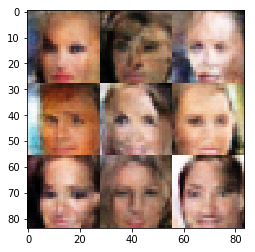

Epoch 1/1... Discriminator Loss: 0.0399... Generator Loss: 7.9077
Epoch 1/1... Discriminator Loss: 0.0186... Generator Loss: 7.6190
Epoch 1/1... Discriminator Loss: 0.0542... Generator Loss: 3.8758
Epoch 1/1... Discriminator Loss: 0.0600... Generator Loss: 3.2703
Epoch 1/1... Discriminator Loss: 0.1059... Generator Loss: 6.0546
Epoch 1/1... Discriminator Loss: 0.0457... Generator Loss: 3.8416
Epoch 1/1... Discriminator Loss: 0.0838... Generator Loss: 3.5385
Epoch 1/1... Discriminator Loss: 0.0453... Generator Loss: 5.2989
Epoch 1/1... Discriminator Loss: 0.5824... Generator Loss: 3.4369
Epoch 1/1... Discriminator Loss: 0.4198... Generator Loss: 1.7855


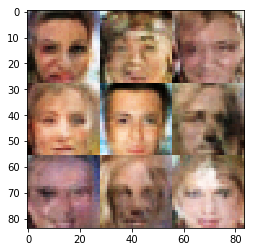

Epoch 1/1... Discriminator Loss: 0.1889... Generator Loss: 2.4100
Epoch 1/1... Discriminator Loss: 0.0407... Generator Loss: 4.8933
Epoch 1/1... Discriminator Loss: 0.0124... Generator Loss: 6.7779
Epoch 1/1... Discriminator Loss: 0.0814... Generator Loss: 3.7238
Epoch 1/1... Discriminator Loss: 0.2090... Generator Loss: 2.0796
Epoch 1/1... Discriminator Loss: 0.0408... Generator Loss: 4.3302
Epoch 1/1... Discriminator Loss: 0.1858... Generator Loss: 2.5787
Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 2.0198
Epoch 1/1... Discriminator Loss: 1.7561... Generator Loss: 0.4160
Epoch 1/1... Discriminator Loss: 0.3413... Generator Loss: 2.3793


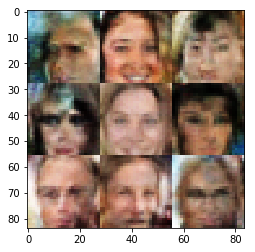

Epoch 1/1... Discriminator Loss: 0.3614... Generator Loss: 1.6742
Epoch 1/1... Discriminator Loss: 0.1121... Generator Loss: 2.7973
Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 4.1082
Epoch 1/1... Discriminator Loss: 0.2747... Generator Loss: 1.9466
Epoch 1/1... Discriminator Loss: 0.0659... Generator Loss: 4.1121
Epoch 1/1... Discriminator Loss: 0.0683... Generator Loss: 3.9464
Epoch 1/1... Discriminator Loss: 0.1428... Generator Loss: 2.4211
Epoch 1/1... Discriminator Loss: 0.0382... Generator Loss: 4.6099
Epoch 1/1... Discriminator Loss: 0.1532... Generator Loss: 2.3284
Epoch 1/1... Discriminator Loss: 2.3244... Generator Loss: 9.5753


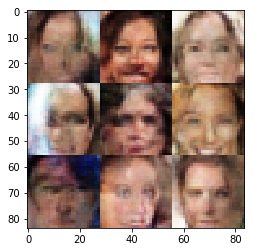

Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 2.2224
Epoch 1/1... Discriminator Loss: 0.1149... Generator Loss: 2.5529
Epoch 1/1... Discriminator Loss: 0.1024... Generator Loss: 3.1289
Epoch 1/1... Discriminator Loss: 0.0483... Generator Loss: 3.6975
Epoch 1/1... Discriminator Loss: 0.0205... Generator Loss: 5.2726
Epoch 1/1... Discriminator Loss: 0.0278... Generator Loss: 4.3259
Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 6.3184
Epoch 1/1... Discriminator Loss: 0.0272... Generator Loss: 5.2646
Epoch 1/1... Discriminator Loss: 0.0753... Generator Loss: 6.5080
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 1.4575


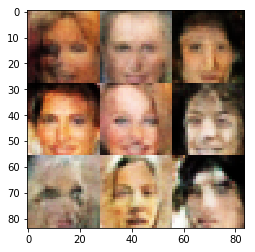

Epoch 1/1... Discriminator Loss: 0.0482... Generator Loss: 4.6916
Epoch 1/1... Discriminator Loss: 0.0171... Generator Loss: 4.9300
Epoch 1/1... Discriminator Loss: 0.0489... Generator Loss: 3.8268
Epoch 1/1... Discriminator Loss: 0.0474... Generator Loss: 3.7279
Epoch 1/1... Discriminator Loss: 0.1057... Generator Loss: 2.9850
Epoch 1/1... Discriminator Loss: 0.4237... Generator Loss: 1.8829
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 1.6473
Epoch 1/1... Discriminator Loss: 0.2677... Generator Loss: 4.7447
Epoch 1/1... Discriminator Loss: 0.0482... Generator Loss: 5.7137
Epoch 1/1... Discriminator Loss: 5.6221... Generator Loss: 11.9862


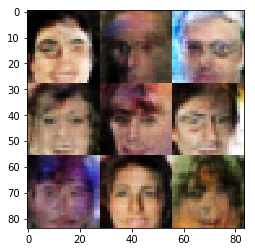

Epoch 1/1... Discriminator Loss: 0.3730... Generator Loss: 1.5671
Epoch 1/1... Discriminator Loss: 0.0364... Generator Loss: 4.6235
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 0.2789... Generator Loss: 2.0703
Epoch 1/1... Discriminator Loss: 0.2375... Generator Loss: 2.2181
Epoch 1/1... Discriminator Loss: 0.2382... Generator Loss: 2.1904
Epoch 1/1... Discriminator Loss: 0.5177... Generator Loss: 1.6634
Epoch 1/1... Discriminator Loss: 0.0855... Generator Loss: 5.7104
Epoch 1/1... Discriminator Loss: 0.0857... Generator Loss: 3.1978


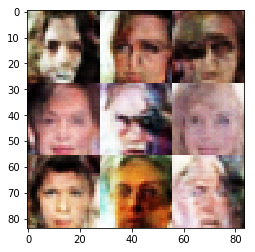

Epoch 1/1... Discriminator Loss: 0.1227... Generator Loss: 3.6340
Epoch 1/1... Discriminator Loss: 0.6052... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 0.0928... Generator Loss: 3.7898
Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 1.7606
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 0.3170... Generator Loss: 2.1795
Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 0.5144


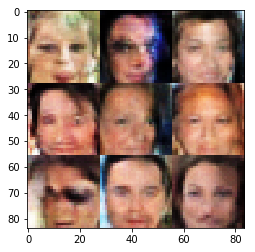

Epoch 1/1... Discriminator Loss: 0.1386... Generator Loss: 4.1358
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 1.4335
Epoch 1/1... Discriminator Loss: 0.2002... Generator Loss: 2.4892
Epoch 1/1... Discriminator Loss: 0.6216... Generator Loss: 1.8027
Epoch 1/1... Discriminator Loss: 0.0605... Generator Loss: 5.6118
Epoch 1/1... Discriminator Loss: 0.0427... Generator Loss: 4.9522
Epoch 1/1... Discriminator Loss: 0.0922... Generator Loss: 3.0071
Epoch 1/1... Discriminator Loss: 0.4379... Generator Loss: 1.9947
Epoch 1/1... Discriminator Loss: 0.1149... Generator Loss: 4.0026
Epoch 1/1... Discriminator Loss: 0.0975... Generator Loss: 3.2502


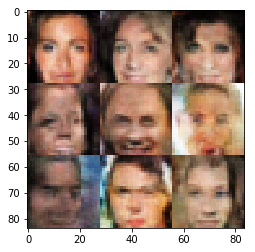

Epoch 1/1... Discriminator Loss: 0.0383... Generator Loss: 4.3608
Epoch 1/1... Discriminator Loss: 0.1792... Generator Loss: 2.2441
Epoch 1/1... Discriminator Loss: 0.0880... Generator Loss: 3.8237
Epoch 1/1... Discriminator Loss: 4.3645... Generator Loss: 0.0217
Epoch 1/1... Discriminator Loss: 0.0668... Generator Loss: 4.4271
Epoch 1/1... Discriminator Loss: 0.0325... Generator Loss: 4.4863
Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 1.5684
Epoch 1/1... Discriminator Loss: 3.6463... Generator Loss: 0.0551
Epoch 1/1... Discriminator Loss: 0.2325... Generator Loss: 2.0850
Epoch 1/1... Discriminator Loss: 0.1881... Generator Loss: 2.4446


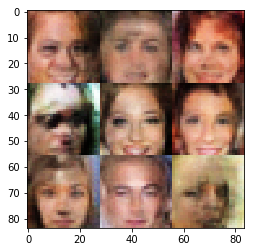

Epoch 1/1... Discriminator Loss: 0.2162... Generator Loss: 6.4487
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 0.0705... Generator Loss: 3.4487
Epoch 1/1... Discriminator Loss: 0.4127... Generator Loss: 1.6944
Epoch 1/1... Discriminator Loss: 0.0316... Generator Loss: 4.7866
Epoch 1/1... Discriminator Loss: 0.0608... Generator Loss: 4.1573
Epoch 1/1... Discriminator Loss: 0.1176... Generator Loss: 2.8008
Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 3.2739
Epoch 1/1... Discriminator Loss: 0.3356... Generator Loss: 2.0434


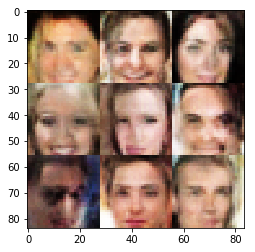

Epoch 1/1... Discriminator Loss: 1.8781... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 0.3705... Generator Loss: 1.7673
Epoch 1/1... Discriminator Loss: 0.0518... Generator Loss: 4.0192
Epoch 1/1... Discriminator Loss: 0.2569... Generator Loss: 2.1108
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 5.9977
Epoch 1/1... Discriminator Loss: 0.1669... Generator Loss: 3.0362
Epoch 1/1... Discriminator Loss: 5.0521... Generator Loss: 11.1668
Epoch 1/1... Discriminator Loss: 0.2033... Generator Loss: 2.7347
Epoch 1/1... Discriminator Loss: 0.1674... Generator Loss: 2.6757
Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 4.8537


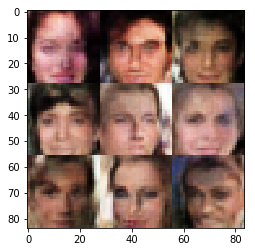

Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 2.7855
Epoch 1/1... Discriminator Loss: 0.0496... Generator Loss: 4.0023
Epoch 1/1... Discriminator Loss: 0.0335... Generator Loss: 4.4503
Epoch 1/1... Discriminator Loss: 0.1640... Generator Loss: 2.9025
Epoch 1/1... Discriminator Loss: 0.0645... Generator Loss: 4.3999
Epoch 1/1... Discriminator Loss: 1.7958... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 0.1487... Generator Loss: 3.3196
Epoch 1/1... Discriminator Loss: 0.1936... Generator Loss: 2.5908
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 1.8852


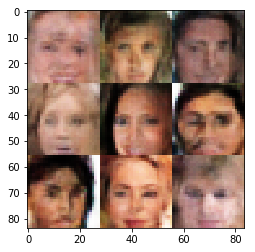

Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 0.0566... Generator Loss: 4.5487
Epoch 1/1... Discriminator Loss: 0.1024... Generator Loss: 2.9615
Epoch 1/1... Discriminator Loss: 0.1074... Generator Loss: 3.8788
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 1.3494
Epoch 1/1... Discriminator Loss: 0.0428... Generator Loss: 4.7302
Epoch 1/1... Discriminator Loss: 0.0444... Generator Loss: 6.8527
Epoch 1/1... Discriminator Loss: 0.0174... Generator Loss: 5.2147
Epoch 1/1... Discriminator Loss: 0.1324... Generator Loss: 2.4425
Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 0.9341


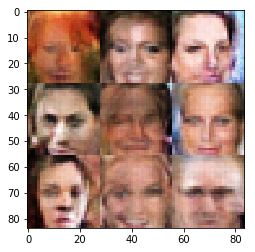

Epoch 1/1... Discriminator Loss: 0.1408... Generator Loss: 3.0455
Epoch 1/1... Discriminator Loss: 0.4237... Generator Loss: 1.3705
Epoch 1/1... Discriminator Loss: 0.1028... Generator Loss: 3.0787
Epoch 1/1... Discriminator Loss: 0.1237... Generator Loss: 3.0439
Epoch 1/1... Discriminator Loss: 0.1388... Generator Loss: 2.6523
Epoch 1/1... Discriminator Loss: 0.5408... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 0.6720... Generator Loss: 1.0521
Epoch 1/1... Discriminator Loss: 0.0707... Generator Loss: 3.3051
Epoch 1/1... Discriminator Loss: 0.1838... Generator Loss: 2.4747
Epoch 1/1... Discriminator Loss: 0.2234... Generator Loss: 4.3120


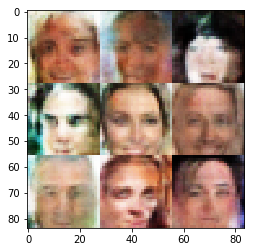

Epoch 1/1... Discriminator Loss: 1.8622... Generator Loss: 0.2827
Epoch 1/1... Discriminator Loss: 0.0247... Generator Loss: 5.4341
Epoch 1/1... Discriminator Loss: 0.5638... Generator Loss: 1.7098
Epoch 1/1... Discriminator Loss: 0.0110... Generator Loss: 5.6214
Epoch 1/1... Discriminator Loss: 0.0267... Generator Loss: 5.1515
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 1.9972
Epoch 1/1... Discriminator Loss: 0.1561... Generator Loss: 2.7116
Epoch 1/1... Discriminator Loss: 0.0603... Generator Loss: 3.7076
Epoch 1/1... Discriminator Loss: 0.0363... Generator Loss: 3.9296
Epoch 1/1... Discriminator Loss: 0.1492... Generator Loss: 3.8510


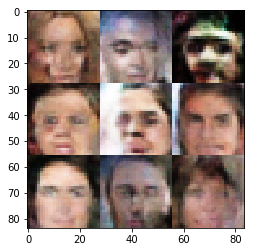

Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 0.5417... Generator Loss: 1.4337
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 5.6224
Epoch 1/1... Discriminator Loss: 0.0097... Generator Loss: 5.9743
Epoch 1/1... Discriminator Loss: 0.2287... Generator Loss: 1.9622
Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 5.3612
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 0.0183... Generator Loss: 6.5760
Epoch 1/1... Discriminator Loss: 0.0461... Generator Loss: 3.8005
Epoch 1/1... Discriminator Loss: 0.7213... Generator Loss: 0.8767


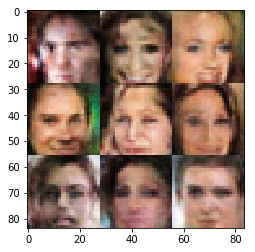

Epoch 1/1... Discriminator Loss: 0.2049... Generator Loss: 3.2993
Epoch 1/1... Discriminator Loss: 0.2123... Generator Loss: 2.1725
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 5.1258
Epoch 1/1... Discriminator Loss: 0.2115... Generator Loss: 2.6860
Epoch 1/1... Discriminator Loss: 0.4497... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 0.1623... Generator Loss: 2.7630
Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 1.3133
Epoch 1/1... Discriminator Loss: 0.2833... Generator Loss: 1.9619
Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 1.7136
Epoch 1/1... Discriminator Loss: 0.3233... Generator Loss: 1.6486


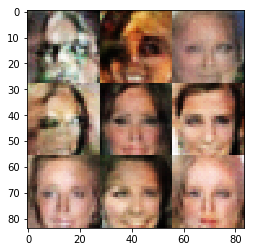

Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.4152
Epoch 1/1... Discriminator Loss: 0.3008... Generator Loss: 1.9860
Epoch 1/1... Discriminator Loss: 0.0927... Generator Loss: 4.1779
Epoch 1/1... Discriminator Loss: 0.2184... Generator Loss: 2.6784
Epoch 1/1... Discriminator Loss: 0.2479... Generator Loss: 3.1841
Epoch 1/1... Discriminator Loss: 0.2154... Generator Loss: 2.6515
Epoch 1/1... Discriminator Loss: 0.0759... Generator Loss: 3.6780
Epoch 1/1... Discriminator Loss: 0.0508... Generator Loss: 4.1753
Epoch 1/1... Discriminator Loss: 0.2593... Generator Loss: 2.2082
Epoch 1/1... Discriminator Loss: 0.0461... Generator Loss: 4.2567


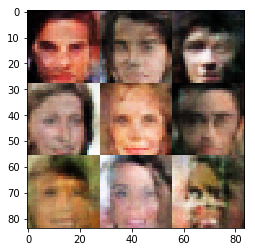

Epoch 1/1... Discriminator Loss: 0.2066... Generator Loss: 2.3296
Epoch 1/1... Discriminator Loss: 0.1507... Generator Loss: 2.9224
Epoch 1/1... Discriminator Loss: 0.0347... Generator Loss: 3.9503
Epoch 1/1... Discriminator Loss: 0.0356... Generator Loss: 3.6675
Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 5.0492
Epoch 1/1... Discriminator Loss: 0.2953... Generator Loss: 1.6804
Epoch 1/1... Discriminator Loss: 0.4087... Generator Loss: 1.8754
Epoch 1/1... Discriminator Loss: 2.2980... Generator Loss: 0.2372
Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 1.3162
Epoch 1/1... Discriminator Loss: 2.0892... Generator Loss: 0.2232


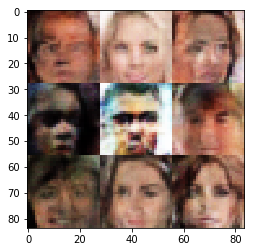

Epoch 1/1... Discriminator Loss: 0.0398... Generator Loss: 4.7694
Epoch 1/1... Discriminator Loss: 0.3317... Generator Loss: 1.9214
Epoch 1/1... Discriminator Loss: 0.0744... Generator Loss: 3.3636
Epoch 1/1... Discriminator Loss: 0.0990... Generator Loss: 5.5548
Epoch 1/1... Discriminator Loss: 0.3191... Generator Loss: 3.0839
Epoch 1/1... Discriminator Loss: 0.1024... Generator Loss: 3.4359
Epoch 1/1... Discriminator Loss: 0.0278... Generator Loss: 4.5711
Epoch 1/1... Discriminator Loss: 0.0534... Generator Loss: 3.5588
Epoch 1/1... Discriminator Loss: 2.9884... Generator Loss: 0.0861
Epoch 1/1... Discriminator Loss: 0.0202... Generator Loss: 6.4646


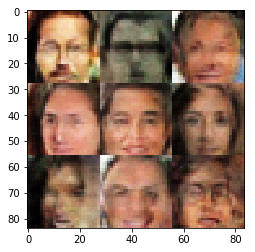

Epoch 1/1... Discriminator Loss: 1.9095... Generator Loss: 0.3333
Epoch 1/1... Discriminator Loss: 0.5305... Generator Loss: 5.3344
Epoch 1/1... Discriminator Loss: 0.4888... Generator Loss: 1.3177
Epoch 1/1... Discriminator Loss: 0.0894... Generator Loss: 3.0782
Epoch 1/1... Discriminator Loss: 3.0667... Generator Loss: 0.1511
Epoch 1/1... Discriminator Loss: 0.2694... Generator Loss: 1.7919
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 0.3741... Generator Loss: 1.8954
Epoch 1/1... Discriminator Loss: 0.1730... Generator Loss: 3.7692
Epoch 1/1... Discriminator Loss: 0.1638... Generator Loss: 2.6555


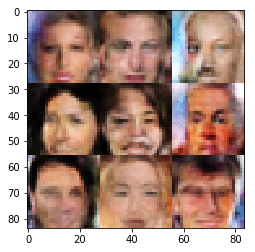

Epoch 1/1... Discriminator Loss: 0.1016... Generator Loss: 3.2229
Epoch 1/1... Discriminator Loss: 0.7121... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 0.2519... Generator Loss: 1.7721
Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.4700
Epoch 1/1... Discriminator Loss: 0.0322... Generator Loss: 5.1026
Epoch 1/1... Discriminator Loss: 0.3513... Generator Loss: 1.9442
Epoch 1/1... Discriminator Loss: 2.7844... Generator Loss: 8.1882
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 0.2158... Generator Loss: 2.6375


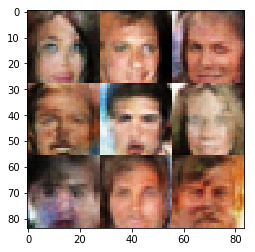

Epoch 1/1... Discriminator Loss: 1.7389... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 0.0556... Generator Loss: 4.2929
Epoch 1/1... Discriminator Loss: 0.0186... Generator Loss: 5.7501
Epoch 1/1... Discriminator Loss: 0.0308... Generator Loss: 5.7443
Epoch 1/1... Discriminator Loss: 0.1661... Generator Loss: 3.3314
Epoch 1/1... Discriminator Loss: 0.1078... Generator Loss: 2.8694
Epoch 1/1... Discriminator Loss: 0.0184... Generator Loss: 6.1104
Epoch 1/1... Discriminator Loss: 0.0298... Generator Loss: 4.7450
Epoch 1/1... Discriminator Loss: 0.1139... Generator Loss: 3.8214
Epoch 1/1... Discriminator Loss: 0.0543... Generator Loss: 6.2493


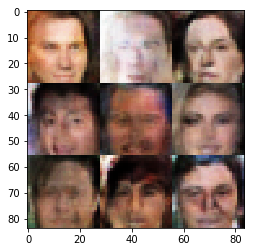

Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 1.3919
Epoch 1/1... Discriminator Loss: 0.4462... Generator Loss: 1.8897
Epoch 1/1... Discriminator Loss: 1.8544... Generator Loss: 0.4109
Epoch 1/1... Discriminator Loss: 0.1874... Generator Loss: 2.7406
Epoch 1/1... Discriminator Loss: 0.0174... Generator Loss: 5.4439
Epoch 1/1... Discriminator Loss: 0.3386... Generator Loss: 1.9517


In [38]:
batch_size = 16
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.